## Setup, Loading Data and CDFs

In [ ]:
DATA_NAME = 'pastis-full' 
TRANSFORM = 'fourier'
CHANNEL = 'blue'

In [2]:
path_list = DATA_NAME.split("-") + TRANSFORM.split("-")
if CHANNEL:
    path_list.append(CHANNEL)
print(f"Name the notebook:\n{'_'.join(path_list[::-1])}.ipynb")
FULL_DATA_NAME='-'.join(path_list)

Name the notebook:
red_fourier_full_pastis.ipynb


In [3]:
import git
from pathlib import Path
import os

ROOT_DIR = Path(git.Repo('.', search_parent_directories=True).working_tree_dir)
CWD = os.path.join(ROOT_DIR, "results", "case-studies", *path_list)

assert CWD == os.getcwd()
Path(os.path.join(CWD, "CSVs")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "plots")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "cache")).mkdir(exist_ok=True)

GROUP = 'layer' if TRANSFORM.split("-")[0] == 'wavelet' else ('band' if TRANSFORM.split("-")[0] == 'fourier' else 'error')
RERUN = False
SKIP_OPTIMIZE_STEP = False
CWD

'/Users/brandonmarks/Desktop/hierarchical-bayesian-model-validation/results/case-studies/pastis/full/fourier/red'

In [4]:
os.chdir(os.path.join(ROOT_DIR, "utilities"))
from testing import * # If MATLAB is not installed, open utilities and set to False
from plotting import *
os.chdir(CWD)
np.random.seed(0)

In [5]:
group_data_map = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{FULL_DATA_NAME}.pickle'))
group_total_samples = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{FULL_DATA_NAME}-size.pickle'))

In [6]:
if TRANSFORM == 'fourier':
    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)[::3]
elif TRANSFORM == 'wavelet':
    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)

cdfs_dir = os.path.join(ROOT_DIR, "results", "CDFs")
cdfs_list = sorted([os.path.join(cdfs_dir, i) for i in os.listdir(cdfs_dir)])
all_cdfs = combine_pickles(cdfs_list[0])
for cdf_dir in cdfs_list[:6]: # TODO For quick testing purposes. Currently excluding 20000 CDFs. Use cdfs_list[5:6] to access CDFs/_test
    all_cdfs = all_cdfs | combine_pickles(cdf_dir)
    
# group_data_map = {g : group_data_map[g][::100] for g in GROUPS} # TODO For quick testing purposes
group_total_samples

{2: 31800,
 3: 22260,
 4: 44520,
 5: 41340,
 6: 50880,
 7: 54060,
 8: 66780,
 9: 63600,
 10: 85860,
 11: 104940,
 12: 111300,
 13: 136740,
 14: 162180,
 15: 187620,
 16: 203520,
 17: 257580,
 18: 289380,
 19: 337080,
 20: 381600,
 21: 470640,
 22: 540600,
 23: 610560,
 24: 712320,
 25: 855420,
 26: 973080,
 27: 1154340,
 28: 1316520,
 29: 1376940,
 30: 960360,
 31: 674160,
 32: 419760,
 33: 162180}

Running 12760 CDFs


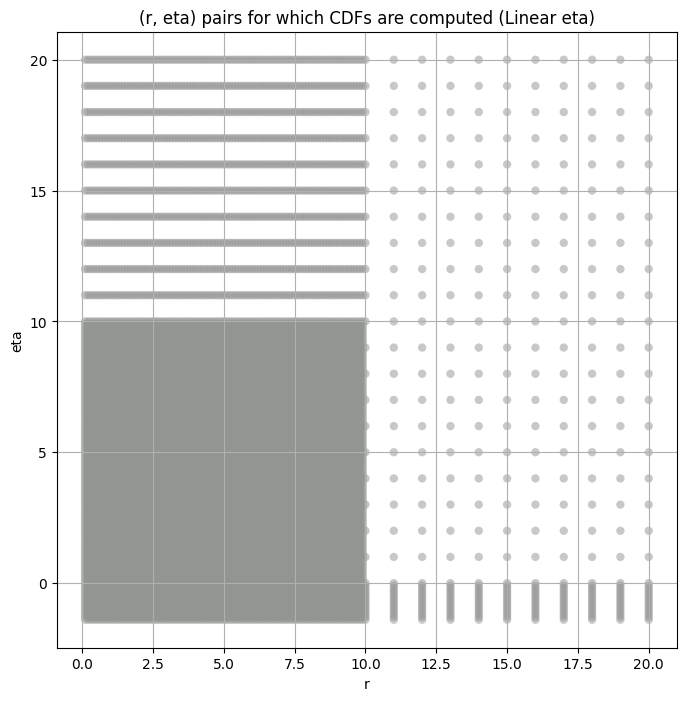

(r,eta),cdf    r  eta  \
0  ((0.1, -1.4), <scipy.interpolate._fitpack2.Int...  0.1 -1.4   
1  ((0.1, -1.3), <scipy.interpolate._fitpack2.Int...  0.1 -1.3   
2  ((0.1, -1.2), <scipy.interpolate._fitpack2.Int...  0.1 -1.2   
3  ((0.1, -1.1), <scipy.interpolate._fitpack2.Int...  0.1 -1.1   
4  ((0.1, -1.0), <scipy.interpolate._fitpack2.Int...  0.1 -1.0   

                                                 cdf      variance  \
0  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.628800e+06   
1  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.991680e+07   
2  <scipy.interpolate._fitpack2.InterpolatedUniva...  2.395008e+08   
3  <scipy.interpolate._fitpack2.InterpolatedUniva...  1.037837e+09   
4  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.632429e+09   

        kurtosis  
0  554265.000000  
1   96192.272727  
2   29390.000000  
3   11997.692308  
4    5874.890110

In [7]:
warnings.filterwarnings('ignore', category=RuntimeWarning)

all_cdfs_df = create_kurt_var_ksstat_df(all_cdfs)
fine_cdfs_df = all_cdfs_df.copy()
all_cdfs_df = all_cdfs_df[(np.round(all_cdfs_df['r'], 1) == all_cdfs_df['r']) & (np.round(all_cdfs_df['eta'], 1) == all_cdfs_df['eta'])]
all_cdfs_df = all_cdfs_df.reset_index(drop=True)
all_cdfs = {x[0] : x[1] for x in all_cdfs_df["(r,eta),cdf"]}
                                             
var_values_dict = dict()
kurt_values_dict = dict()
master_df = pd.DataFrame(columns=[GROUP]).set_index(GROUP)
temp_cdf = all_cdfs_df
print(f"Running {all_cdfs_df.shape[0]} CDFs")
create_scatter_plot(all_cdfs_df);
all_cdfs_df.head()

## Bootstrapping the Variance and Kurtosis

In [8]:
n_bootstrap = int(1e5) # TODO For quick testing purposes
bootstrap_size = int(1e4) # TODO For quick testing purposes
ci = 0.99

In [9]:
bootstrap_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))
master_df_var_kurt_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

if RERUN or not master_df_var_kurt_path.exists(): # TODO For quick testing purposes
    for group in GROUPS:
        print(f'{GROUP.capitalize()} {group}')
        obs_var, var_lower, var_upper, var_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                n_bootstrap=n_bootstrap, 
                                                                                bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                metric= np.var, 
                                                                                ci=ci)
        obs_kurt, kurt_lower, kurt_upper, kurt_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                    n_bootstrap=n_bootstrap, 
                                                                                    bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                    metric= stats.kurtosis, ci=ci)  
        master_df.loc[group, 'obs_var'], master_df.loc[group, 'var_lower'], master_df.loc[group, 'var_upper'] = obs_var, var_lower, var_upper
        master_df.loc[group, 'obs_kurt'], master_df.loc[group, 'kurt_lower'], master_df.loc[group, 'kurt_upper'] = obs_kurt, kurt_lower, kurt_upper
        master_df.loc[group, 'total_samples'] = group_total_samples[group]

    master_df.to_csv(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

master_df = pd.read_csv(master_df_var_kurt_path, index_col=GROUP)
var_kurt_df = pd.read_csv(bootstrap_path, index_col=GROUP)
master_df

Band 2


100%|██████████| 100000/100000 [01:05<00:00, 1538.35it/s]


Band 5


100%|██████████| 100000/100000 [01:17<00:00, 1291.84it/s]


Band 8


100%|██████████| 100000/100000 [1:07:22<00:00, 24.74it/s]  


Band 11


100%|██████████| 100000/100000 [01:07<00:00, 1486.97it/s]


Band 14


100%|██████████| 100000/100000 [01:13<00:00, 1367.67it/s]


Band 17


100%|██████████| 100000/100000 [01:07<00:00, 1480.30it/s]


Band 20


100%|██████████| 100000/100000 [05:45<00:00, 289.15it/s]


Band 23


100%|██████████| 100000/100000 [02:06<00:00, 787.47it/s]


Band 26


100%|██████████| 100000/100000 [10:39<00:00, 156.47it/s]


Band 29


100%|██████████| 100000/100000 [01:14<00:00, 1349.50it/s]


Band 32


100%|██████████| 100000/100000 [01:08<00:00, 1456.18it/s]


obs_var  var_lower  var_upper   obs_kurt  kurt_lower  kurt_upper  \
band                                                                      
2     9.598991   9.110358  10.110742   2.019593    1.471349    2.704436   
5     5.091696   4.837473   5.358150   1.903983    1.275784    2.832162   
8     2.783870   2.644551   2.927817   1.937604    1.312301    2.837549   
11    1.574336   1.491815   1.662111   2.370253    1.365877    4.514517   
14    0.857636   0.814612   0.903813   2.089291    1.275146    4.009901   
17    0.483346   0.458738   0.509555   2.151878    1.293355    4.513294   
20    0.247357   0.234671   0.261674   2.416864    1.276760    9.097979   
23    0.120827   0.114650   0.127477   2.248149    1.370794    4.596758   
26    0.052979   0.049797   0.057025   4.653831    1.694718   18.998148   
29    0.020105   0.018494   0.022679  13.155254    2.838861   66.098460   
32    0.002715   0.002586   0.002847   1.459712    1.005672    2.262223   

      total_samples  
band                 
2           31800.0  
5           41340.0  
8           66780.0  
11         104940.0  
14         162180.0  
17         257580.0  
20         381600.0  
23         610560.0  
26         973080.0  
29        1376940.0  
32         419760.0

## Initial Grid Search and Hypothesis Test Plots

In [10]:
EXCLUDE_CUTOFFS = [0, 25, 50, 75, 100, 150, 200, 250, 300, 350, 500] # TODO For quick testing purposes
SCALE_CAP = 1e5

In [11]:
augmented_var_df_path = Path(os.path.join(CWD, "CSVs", "augmented_var_df.csv"))
augmented_var_df = var_kurt_df[['obs_var']].copy()
augmented_var_df
for val in EXCLUDE_CUTOFFS:
    temp_arr = []
    for group in GROUPS:
        if val != 0:
            temp_arr.append(np.var(group_data_map[group][val:-val]))
        else:
            temp_arr.append(np.var(group_data_map[group]))

    augmented_var_df[f"var_exclude_{val}"] = temp_arr
augmented_var_df

obs_var  var_exclude_0  var_exclude_25  var_exclude_50  var_exclude_75  \
band                                                                            
2     9.598991       9.598991        9.229053        8.988859        8.795794   
5     5.091696       5.091696        4.928396        4.830059        4.747922   
8     2.783870       2.783870        2.720212        2.681151        2.647512   
11    1.574336       1.574336        1.541339        1.523067        1.507714   
14    0.857636       0.857636        0.841638        0.832229        0.824339   
17    0.483346       0.483346        0.474015        0.468667        0.464234   
20    0.247357       0.247357        0.242687        0.240042        0.237782   
23    0.120827       0.120827        0.118484        0.117112        0.115973   
26    0.052979       0.052979        0.051408        0.050683        0.050109   
29    0.020105       0.020105        0.019033        0.018621        0.018328   
32    0.002715       0.002715        0.002676        0.002650        0.002627   

      var_exclude_100  var_exclude_150  var_exclude_200  var_exclude_250  \
band                                                                       
2            8.628831         8.336626         8.087207         7.866261   
5            4.675750         4.549448         4.440252         4.342916   
8            2.617065         2.563734         2.517256         2.475539   
11           1.494240         1.471068         1.450757         1.432367   
14           0.817291         0.804897         0.794031         0.784197   
17           0.460283         0.453394         0.447283         0.441738   
20           0.235765         0.232194         0.229052         0.226203   
23           0.114961         0.113179         0.111611         0.110191   
26           0.049617         0.048776         0.048049         0.047399   
29           0.018093         0.017712         0.017401         0.017133   
32           0.002607         0.002571         0.002539         0.002510   

      var_exclude_300  var_exclude_350  var_exclude_500  
band                                                     
2            7.668087         7.487642         7.013214  
5            4.252742         4.169448         3.948290  
8            2.437394         2.402038         2.308125  
11           1.415398         1.399655         1.357384  
14           0.775065         0.766524         0.743623  
17           0.436589         0.431795         0.418914  
20           0.223566         0.221104         0.214499  
23           0.108885         0.107671         0.104404  
26           0.046807         0.046260         0.044811  
29           0.016894         0.016677         0.016114  
32           0.002482         0.002457         0.002388

####
Band  2


100%|██████████| 12760/12760 [00:26<00:00, 490.66it/s]


Finding Minimum after computing 12760 CDFs
2 0 0.0035237300440779107 9.598991


100%|██████████| 12760/12760 [00:22<00:00, 577.00it/s]


Finding Minimum after computing 12760 CDFs
2 25 0.0034249890778964565 9.2290535


100%|██████████| 12760/12760 [00:22<00:00, 566.69it/s]


Finding Minimum after computing 12760 CDFs
2 50 0.003721001419846548 8.988859


100%|██████████| 12760/12760 [00:22<00:00, 561.82it/s]


Finding Minimum after computing 12760 CDFs
2 75 0.004664092487647764 8.7957945


100%|██████████| 12760/12760 [00:25<00:00, 490.92it/s]


Finding Minimum after computing 12760 CDFs
2 100 0.005670036266561429 8.628831


100%|██████████| 12760/12760 [00:25<00:00, 491.26it/s]


Finding Minimum after computing 12760 CDFs
2 150 0.007462316375744682 8.336626


100%|██████████| 12760/12760 [00:22<00:00, 563.90it/s]


Finding Minimum after computing 12760 CDFs
2 200 0.00910169210767442 8.087207


100%|██████████| 12760/12760 [00:24<00:00, 517.53it/s]


Finding Minimum after computing 12760 CDFs
2 250 0.010952287492172835 7.8662605


100%|██████████| 12760/12760 [00:21<00:00, 585.05it/s]


Finding Minimum after computing 12760 CDFs
2 300 0.012954430117955731 7.6680865


100%|██████████| 12760/12760 [00:21<00:00, 582.50it/s]


Finding Minimum after computing 12760 CDFs
2 350 0.014898387324348991 7.487642


100%|██████████| 12760/12760 [00:21<00:00, 581.54it/s]


Finding Minimum after computing 12760 CDFs
2 500 0.02040257406015765 7.0132136
Number of samples: 31800, Without approximation : 31800.0


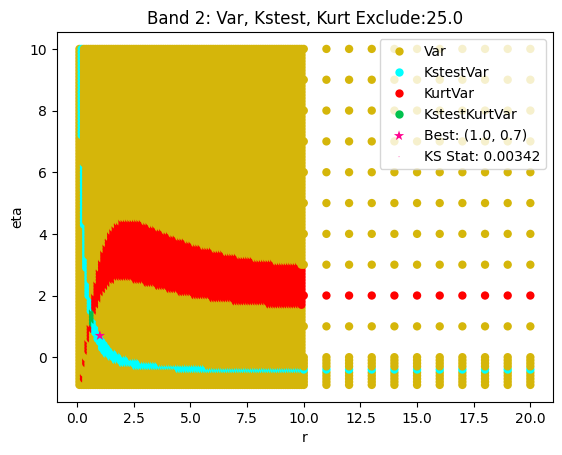

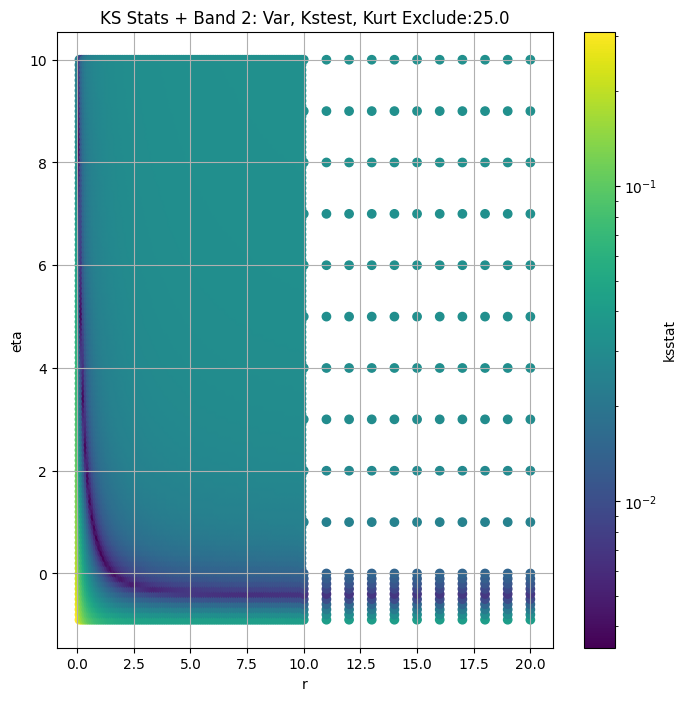

####
Band  5


100%|██████████| 12760/12760 [00:28<00:00, 453.74it/s]


Finding Minimum after computing 12760 CDFs
5 0 0.0022623140546526033 5.0916963


100%|██████████| 12760/12760 [00:28<00:00, 451.75it/s]


Finding Minimum after computing 12760 CDFs
5 25 0.002274567767181268 4.9283957


100%|██████████| 12760/12760 [00:28<00:00, 454.74it/s]


Finding Minimum after computing 12760 CDFs
5 50 0.002827993467594214 4.8300586


100%|██████████| 12760/12760 [00:28<00:00, 454.32it/s]


Finding Minimum after computing 12760 CDFs
5 75 0.003525997091696098 4.7479224


100%|██████████| 12760/12760 [00:28<00:00, 446.41it/s]


Finding Minimum after computing 12760 CDFs
5 100 0.004230933181632257 4.6757503


100%|██████████| 12760/12760 [00:28<00:00, 453.33it/s]


Finding Minimum after computing 12760 CDFs
5 150 0.00558518467332858 4.549448


100%|██████████| 12760/12760 [00:28<00:00, 448.63it/s]


Finding Minimum after computing 12760 CDFs
5 200 0.0069155144427560655 4.4402523


100%|██████████| 12760/12760 [00:28<00:00, 451.03it/s]


Finding Minimum after computing 12760 CDFs
5 250 0.008144891281959277 4.342916


100%|██████████| 12760/12760 [00:28<00:00, 448.28it/s]


Finding Minimum after computing 12760 CDFs
5 300 0.009607275393985093 4.2527423


100%|██████████| 12760/12760 [00:27<00:00, 455.83it/s]


Finding Minimum after computing 12760 CDFs
5 350 0.01112656342734486 4.1694484


100%|██████████| 12760/12760 [00:29<00:00, 427.89it/s]


Finding Minimum after computing 12760 CDFs
5 500 0.015846357800792354 3.9482896
Number of samples: 41340, Without approximation : 41340.0


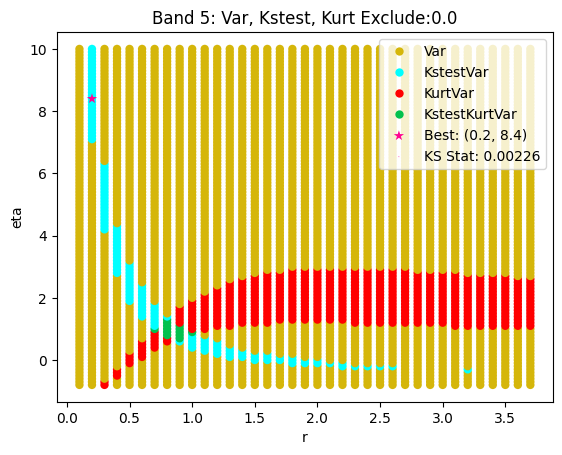

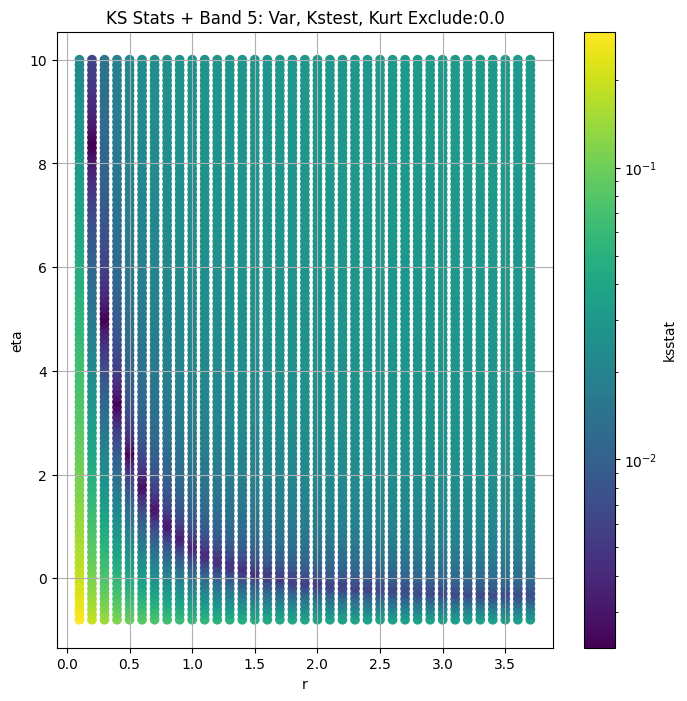

####
Band  8


100%|██████████| 12760/12760 [00:49<00:00, 255.51it/s]


Finding Minimum after computing 12760 CDFs
8 0 0.0032650376270186854 2.78387


100%|██████████| 12760/12760 [00:48<00:00, 263.22it/s]


Finding Minimum after computing 12760 CDFs
8 25 0.003270802653581817 2.7202117


100%|██████████| 12760/12760 [00:48<00:00, 261.03it/s]


Finding Minimum after computing 12760 CDFs
8 50 0.0032909764198563174 2.6811512


100%|██████████| 12760/12760 [00:45<00:00, 283.00it/s]


Finding Minimum after computing 12760 CDFs
8 75 0.003301832803383087 2.6475122


100%|██████████| 12760/12760 [00:44<00:00, 284.91it/s]


Finding Minimum after computing 12760 CDFs
8 100 0.0033459416147150756 2.6170647


100%|██████████| 12760/12760 [00:44<00:00, 283.68it/s]


Finding Minimum after computing 12760 CDFs
8 150 0.003977926426909195 2.563734


100%|██████████| 12760/12760 [00:44<00:00, 283.78it/s]


Finding Minimum after computing 12760 CDFs
8 200 0.00494619971023047 2.5172563


100%|██████████| 12760/12760 [00:45<00:00, 277.92it/s]


Finding Minimum after computing 12760 CDFs
8 250 0.0058190366587766995 2.4755394


100%|██████████| 12760/12760 [00:44<00:00, 284.77it/s]


Finding Minimum after computing 12760 CDFs
8 300 0.006805953584768876 2.4373937


100%|██████████| 12760/12760 [00:44<00:00, 284.53it/s]


Finding Minimum after computing 12760 CDFs
8 350 0.00773188149111248 2.4020376


100%|██████████| 12760/12760 [00:45<00:00, 280.65it/s]


Finding Minimum after computing 12760 CDFs
8 500 0.010414978682665832 2.3081248
Number of samples: 66780, Without approximation : 66780.0


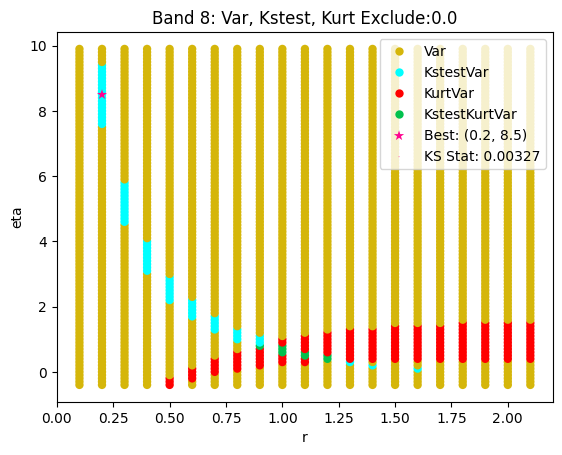

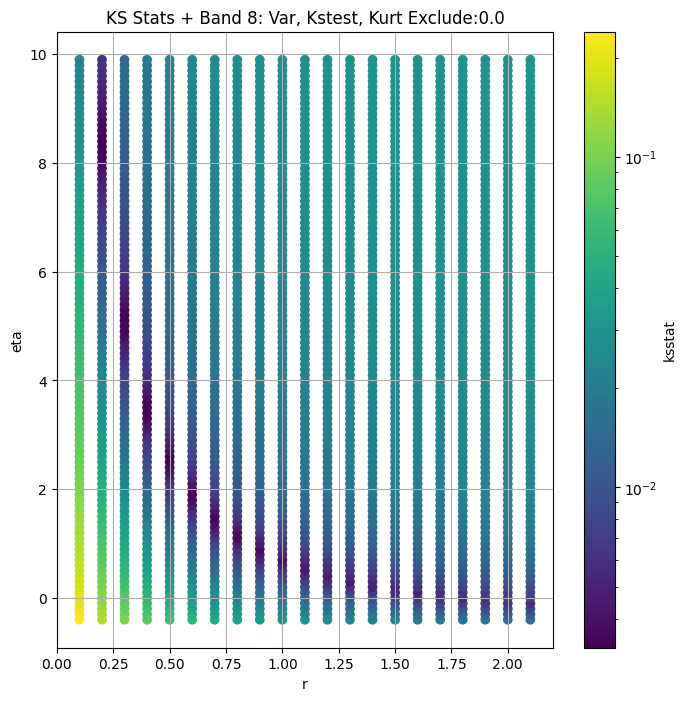

####
Band  11


100%|██████████| 12760/12760 [01:08<00:00, 186.10it/s]


Finding Minimum after computing 12760 CDFs
11 0 0.001712402030862814 1.574336


100%|██████████| 12760/12760 [01:12<00:00, 175.97it/s]


Finding Minimum after computing 12760 CDFs
11 25 0.0016488965219491614 1.5413389


100%|██████████| 12760/12760 [01:06<00:00, 191.44it/s]


Finding Minimum after computing 12760 CDFs
11 50 0.0016630643272853574 1.523067


100%|██████████| 12760/12760 [01:07<00:00, 189.84it/s]


Finding Minimum after computing 12760 CDFs
11 75 0.00176190653217502 1.507714


100%|██████████| 12760/12760 [01:06<00:00, 190.50it/s]


Finding Minimum after computing 12760 CDFs
11 100 0.0018557141108572206 1.49424


100%|██████████| 12760/12760 [01:07<00:00, 188.52it/s]


Finding Minimum after computing 12760 CDFs
11 150 0.0025055553144935436 1.4710683


100%|██████████| 12760/12760 [01:08<00:00, 185.62it/s]


Finding Minimum after computing 12760 CDFs
11 200 0.003166084152015072 1.4507574


100%|██████████| 12760/12760 [01:21<00:00, 156.76it/s]


Finding Minimum after computing 12760 CDFs
11 250 0.0037778543460493808 1.4323672


100%|██████████| 12760/12760 [01:06<00:00, 190.93it/s]


Finding Minimum after computing 12760 CDFs
11 300 0.004381221888040798 1.4153981


100%|██████████| 12760/12760 [01:07<00:00, 189.72it/s]


Finding Minimum after computing 12760 CDFs
11 350 0.004934854595128435 1.3996551


100%|██████████| 12760/12760 [01:10<00:00, 180.69it/s]


Finding Minimum after computing 12760 CDFs
11 500 0.00652567827582462 1.3573842
Number of samples: 100000, Without approximation : 104940.0


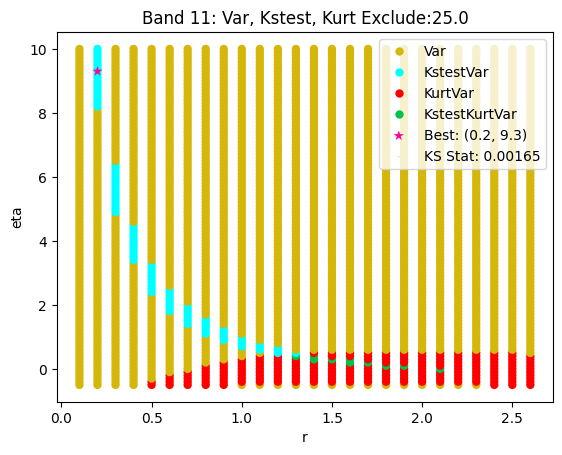

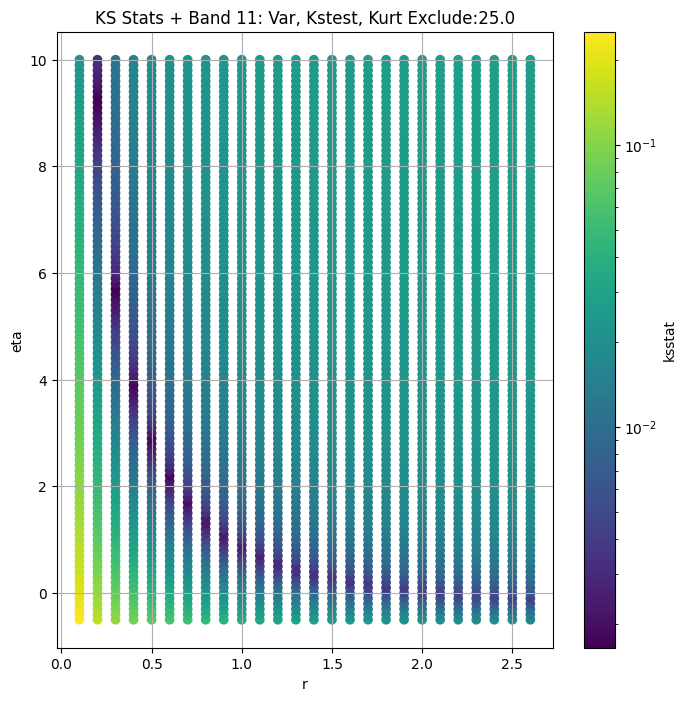

####
Band  14


100%|██████████| 12760/12760 [01:07<00:00, 187.98it/s]


Finding Minimum after computing 12760 CDFs
14 0 0.0025487840596686295 0.8576356


100%|██████████| 12760/12760 [01:10<00:00, 181.15it/s]


Finding Minimum after computing 12760 CDFs
14 25 0.002545224309894567 0.84163815


100%|██████████| 12760/12760 [01:16<00:00, 166.93it/s]


Finding Minimum after computing 12760 CDFs
14 50 0.0025814186525848215 0.8322288


100%|██████████| 12760/12760 [01:09<00:00, 182.36it/s]


Finding Minimum after computing 12760 CDFs
14 75 0.002566380146199365 0.82433903


100%|██████████| 12760/12760 [01:08<00:00, 186.22it/s]


Finding Minimum after computing 12760 CDFs
14 100 0.002547166469205664 0.8172912


100%|██████████| 12760/12760 [01:11<00:00, 178.65it/s]


Finding Minimum after computing 12760 CDFs
14 150 0.002912930368667601 0.8048966


100%|██████████| 12760/12760 [01:14<00:00, 170.88it/s]


Finding Minimum after computing 12760 CDFs
14 200 0.003495662780941388 0.79403126


100%|██████████| 12760/12760 [01:07<00:00, 188.74it/s]


Finding Minimum after computing 12760 CDFs
14 250 0.004099763715095461 0.7841967


100%|██████████| 12760/12760 [01:14<00:00, 172.38it/s]


Finding Minimum after computing 12760 CDFs
14 300 0.004678051036785081 0.7750648


100%|██████████| 12760/12760 [01:21<00:00, 156.75it/s]


Finding Minimum after computing 12760 CDFs
14 350 0.005224444504194195 0.76652354


100%|██████████| 12760/12760 [01:11<00:00, 179.59it/s]


Finding Minimum after computing 12760 CDFs
14 500 0.006786033331282925 0.7436229
Number of samples: 100000, Without approximation : 162180.0


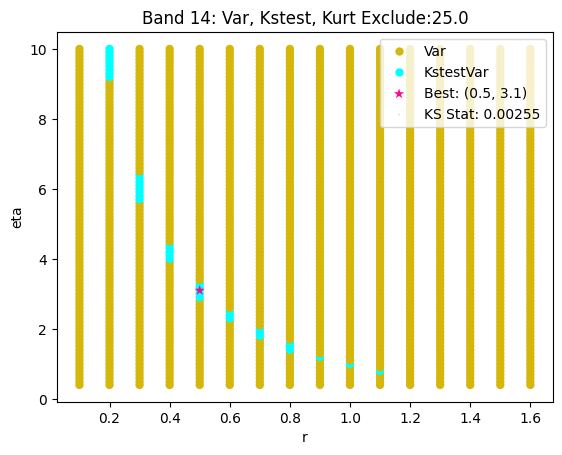

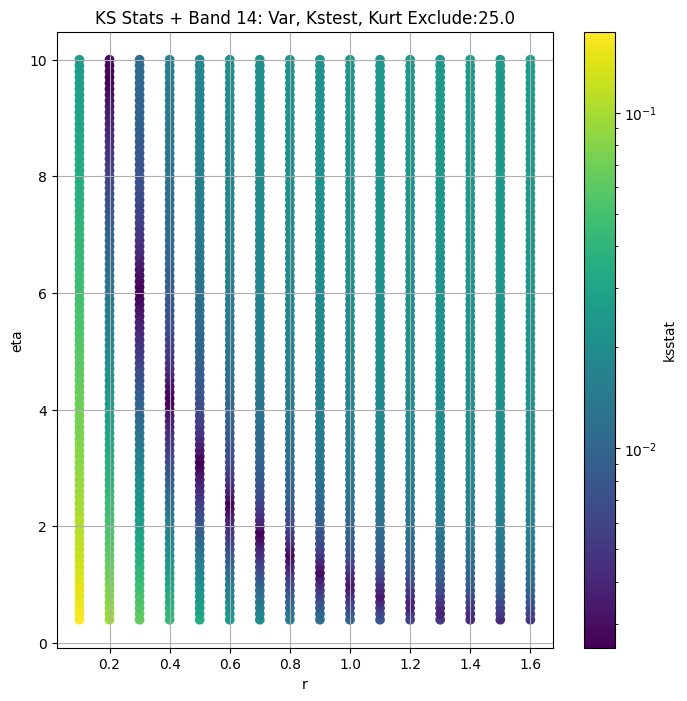

####
Band  17


100%|██████████| 12760/12760 [01:06<00:00, 191.01it/s]


Finding Minimum after computing 12760 CDFs
17 0 0.0009468120631633825 0.4833461


100%|██████████| 12760/12760 [01:08<00:00, 185.94it/s]


Finding Minimum after computing 12760 CDFs
17 25 0.000928131609215177 0.47401547


100%|██████████| 12760/12760 [01:06<00:00, 190.52it/s]


Finding Minimum after computing 12760 CDFs
17 50 0.0013305746340742663 0.46866658


100%|██████████| 12760/12760 [01:06<00:00, 192.24it/s]


Finding Minimum after computing 12760 CDFs
17 75 0.0016226118772540987 0.46423382


100%|██████████| 12760/12760 [01:08<00:00, 185.07it/s]


Finding Minimum after computing 12760 CDFs
17 100 0.001953464118056192 0.46028325


100%|██████████| 12760/12760 [01:06<00:00, 191.88it/s]


Finding Minimum after computing 12760 CDFs
17 150 0.0026520111990556705 0.453394


100%|██████████| 12760/12760 [01:07<00:00, 190.38it/s]


Finding Minimum after computing 12760 CDFs
17 200 0.003292400856150013 0.4472831


100%|██████████| 12760/12760 [01:07<00:00, 190.27it/s]


Finding Minimum after computing 12760 CDFs
17 250 0.003901848487075088 0.44173822


100%|██████████| 12760/12760 [01:06<00:00, 191.41it/s]


Finding Minimum after computing 12760 CDFs
17 300 0.00453921598821061 0.4365889


100%|██████████| 12760/12760 [01:06<00:00, 190.66it/s]


Finding Minimum after computing 12760 CDFs
17 350 0.005145432259750171 0.43179467


100%|██████████| 12760/12760 [01:10<00:00, 181.39it/s]


Finding Minimum after computing 12760 CDFs
17 500 0.006816149221010481 0.4189139
Number of samples: 100000, Without approximation : 257580.0


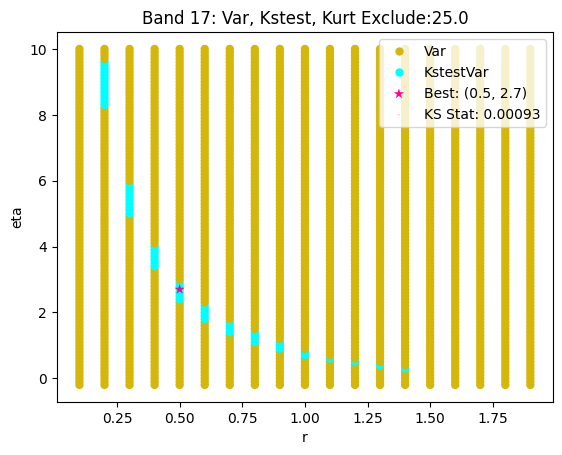

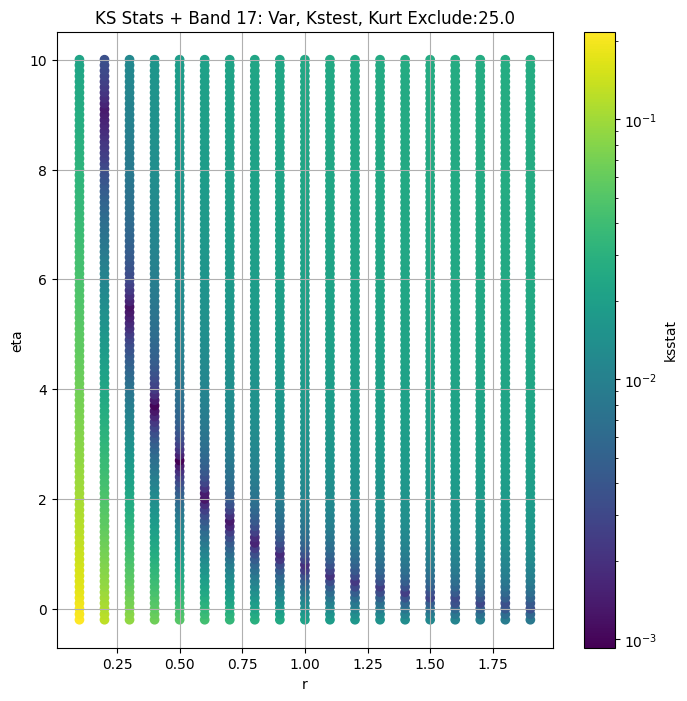

####
Band  20


100%|██████████| 12760/12760 [01:07<00:00, 189.16it/s]


Finding Minimum after computing 12760 CDFs
20 0 0.0010143493665437653 0.24735701


100%|██████████| 12760/12760 [01:06<00:00, 192.49it/s]


Finding Minimum after computing 12760 CDFs
20 25 0.0009826001929819084 0.24268697


100%|██████████| 12760/12760 [01:06<00:00, 191.26it/s]


Finding Minimum after computing 12760 CDFs
20 50 0.0010326045221336483 0.24004164


100%|██████████| 12760/12760 [01:08<00:00, 187.37it/s]


Finding Minimum after computing 12760 CDFs
20 75 0.0014436374436641586 0.23778167


100%|██████████| 12760/12760 [01:06<00:00, 191.87it/s]


Finding Minimum after computing 12760 CDFs
20 100 0.0017621249771280142 0.23576503


100%|██████████| 12760/12760 [01:13<00:00, 174.09it/s]


Finding Minimum after computing 12760 CDFs
20 150 0.0024189632755127755 0.23219362


100%|██████████| 12760/12760 [01:10<00:00, 181.26it/s]


Finding Minimum after computing 12760 CDFs
20 200 0.0030754725196414645 0.2290517


100%|██████████| 12760/12760 [01:06<00:00, 190.53it/s]


Finding Minimum after computing 12760 CDFs
20 250 0.0036735493163186257 0.22620273


100%|██████████| 12760/12760 [01:06<00:00, 191.75it/s]


Finding Minimum after computing 12760 CDFs
20 300 0.0042595261685461905 0.2235664


100%|██████████| 12760/12760 [01:07<00:00, 189.88it/s]


Finding Minimum after computing 12760 CDFs
20 350 0.004859815884512418 0.22110355


100%|██████████| 12760/12760 [01:08<00:00, 187.32it/s]


Finding Minimum after computing 12760 CDFs
20 500 0.00658884457542068 0.21449856
Number of samples: 100000, Without approximation : 381600.0


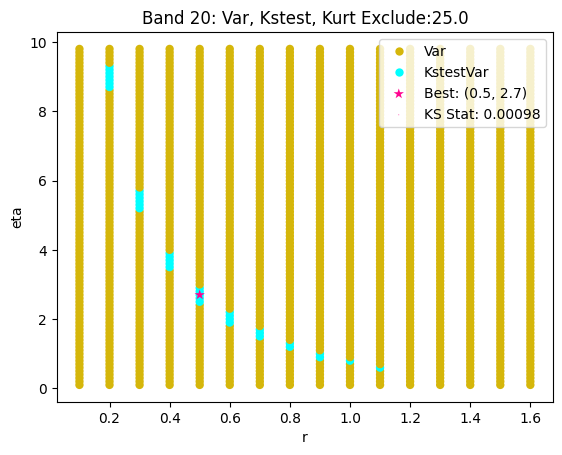

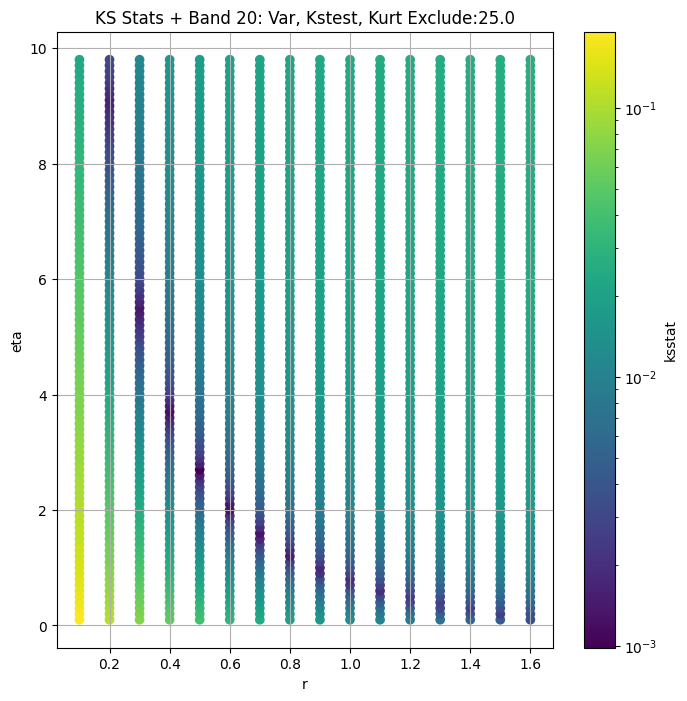

####
Band  23


100%|██████████| 12760/12760 [01:12<00:00, 175.20it/s]


Finding Minimum after computing 12760 CDFs
23 0 0.0011203195272457556 0.12082742


100%|██████████| 12760/12760 [01:21<00:00, 156.99it/s]


Finding Minimum after computing 12760 CDFs
23 25 0.0011464049001574939 0.11848437


100%|██████████| 12760/12760 [49:04<00:00,  4.33it/s]  


Finding Minimum after computing 12760 CDFs
23 50 0.001157166476097038 0.11711237


100%|██████████| 12760/12760 [02:08<00:00, 99.36it/s] 


Finding Minimum after computing 12760 CDFs
23 75 0.0015203178433191855 0.11597315


100%|██████████| 12760/12760 [01:27<00:00, 145.69it/s]


Finding Minimum after computing 12760 CDFs
23 100 0.0018378691947886772 0.11496135


100%|██████████| 12760/12760 [00:42<00:00, 297.57it/s]


Finding Minimum after computing 12760 CDFs
23 150 0.0024835409807802966 0.11317921


100%|██████████| 12760/12760 [00:49<00:00, 257.31it/s]


Finding Minimum after computing 12760 CDFs
23 200 0.0031340167990610013 0.11161105


100%|██████████| 12760/12760 [00:44<00:00, 284.69it/s]


Finding Minimum after computing 12760 CDFs
23 250 0.0037041817009400013 0.11019109


100%|██████████| 12760/12760 [00:45<00:00, 282.65it/s]


Finding Minimum after computing 12760 CDFs
23 300 0.0042582495155558675 0.108884625


100%|██████████| 12760/12760 [00:46<00:00, 273.29it/s]


Finding Minimum after computing 12760 CDFs
23 350 0.004831184025686053 0.107670814


100%|██████████| 12760/12760 [00:43<00:00, 292.23it/s]


Finding Minimum after computing 12760 CDFs
23 500 0.006391597280742456 0.1044037
Number of samples: 100000, Without approximation : 610560.0


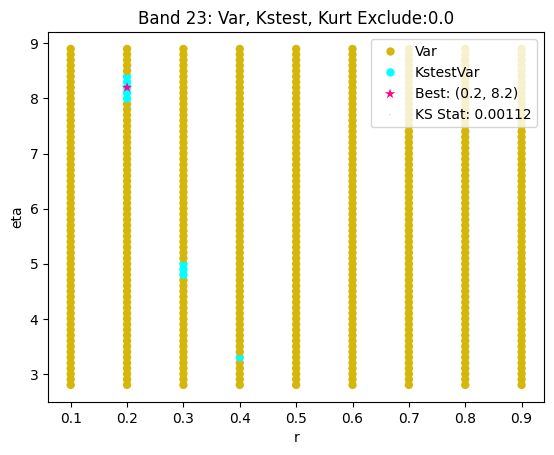

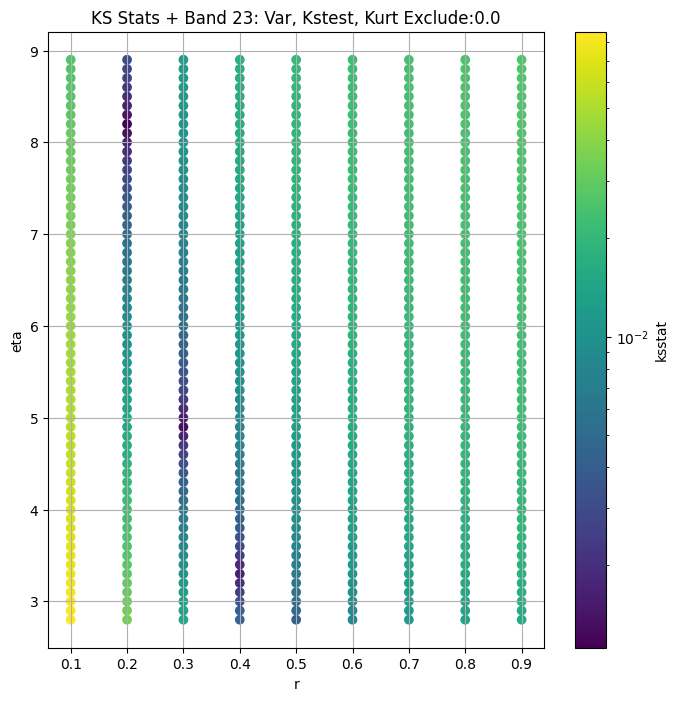

####
Band  26


100%|██████████| 12760/12760 [00:45<00:00, 280.42it/s]


Finding Minimum after computing 12760 CDFs
26 0 0.0019693401777404196 0.052978814


100%|██████████| 12760/12760 [00:42<00:00, 297.80it/s]


Finding Minimum after computing 12760 CDFs
26 25 0.0007234453993844037 0.05140849


100%|██████████| 12760/12760 [00:42<00:00, 298.07it/s]


Finding Minimum after computing 12760 CDFs
26 50 0.0009039204183768357 0.050683048


100%|██████████| 12760/12760 [00:43<00:00, 296.26it/s]


Finding Minimum after computing 12760 CDFs
26 75 0.001259842048190088 0.050109137


100%|██████████| 12760/12760 [00:42<00:00, 298.26it/s]


Finding Minimum after computing 12760 CDFs
26 100 0.0016132167769895567 0.049617417


100%|██████████| 12760/12760 [00:42<00:00, 300.73it/s]


Finding Minimum after computing 12760 CDFs
26 150 0.002262255803957114 0.04877583


100%|██████████| 12760/12760 [00:42<00:00, 300.10it/s]


Finding Minimum after computing 12760 CDFs
26 200 0.0029603178808483843 0.04804924


100%|██████████| 12760/12760 [00:42<00:00, 301.64it/s]


Finding Minimum after computing 12760 CDFs
26 250 0.0035604318740543907 0.047398992


100%|██████████| 12760/12760 [00:43<00:00, 292.74it/s]


Finding Minimum after computing 12760 CDFs
26 300 0.004162905962532073 0.04680734


100%|██████████| 12760/12760 [00:42<00:00, 302.67it/s]


Finding Minimum after computing 12760 CDFs
26 350 0.004724901822651784 0.046260234


100%|██████████| 12760/12760 [00:43<00:00, 296.01it/s]


Finding Minimum after computing 12760 CDFs
26 500 0.006341681168684003 0.044810764
Number of samples: 100000, Without approximation : 973080.0


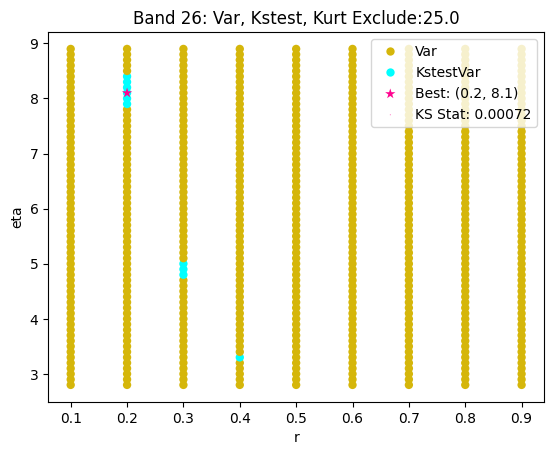

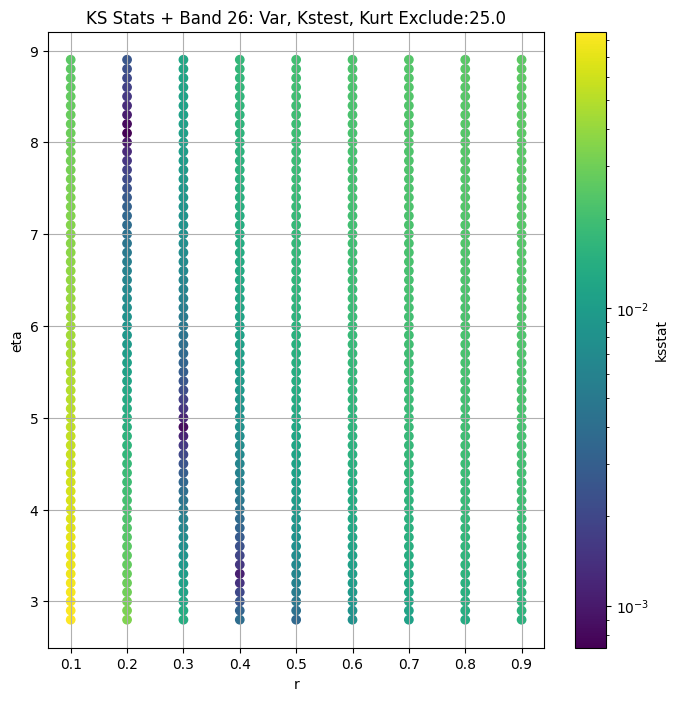

####
Band  29


100%|██████████| 12760/12760 [00:41<00:00, 304.49it/s]


Finding Minimum after computing 12760 CDFs
29 0 0.00481195450808275 0.020104643


100%|██████████| 12760/12760 [00:41<00:00, 310.43it/s]


Finding Minimum after computing 12760 CDFs
29 25 0.0022233514312826747 0.019032864


100%|██████████| 12760/12760 [00:41<00:00, 308.66it/s]


Finding Minimum after computing 12760 CDFs
29 50 0.0011594876442090202 0.018621352


100%|██████████| 12760/12760 [00:41<00:00, 308.46it/s]


Finding Minimum after computing 12760 CDFs
29 75 0.0011608380986497524 0.018328432


100%|██████████| 12760/12760 [00:41<00:00, 309.75it/s]


Finding Minimum after computing 12760 CDFs
29 100 0.0013875138630872197 0.01809283


100%|██████████| 12760/12760 [00:41<00:00, 310.69it/s]


Finding Minimum after computing 12760 CDFs
29 150 0.001966007157180538 0.017711928


100%|██████████| 12760/12760 [00:41<00:00, 310.81it/s]


Finding Minimum after computing 12760 CDFs
29 200 0.0026097484753191402 0.0174011


100%|██████████| 12760/12760 [00:41<00:00, 306.99it/s]


Finding Minimum after computing 12760 CDFs
29 250 0.003233094484473842 0.01713342


100%|██████████| 12760/12760 [00:41<00:00, 310.43it/s]


Finding Minimum after computing 12760 CDFs
29 300 0.003784410804334379 0.01689425


100%|██████████| 12760/12760 [00:41<00:00, 308.07it/s]


Finding Minimum after computing 12760 CDFs
29 350 0.00430189073358795 0.016677277


100%|██████████| 12760/12760 [00:43<00:00, 295.15it/s]


Finding Minimum after computing 12760 CDFs
29 500 0.005988057981000994 0.01611374
Number of samples: 100000, Without approximation : 1376940.0


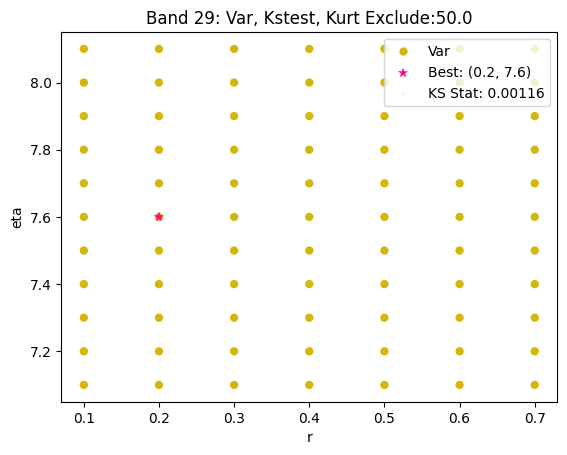

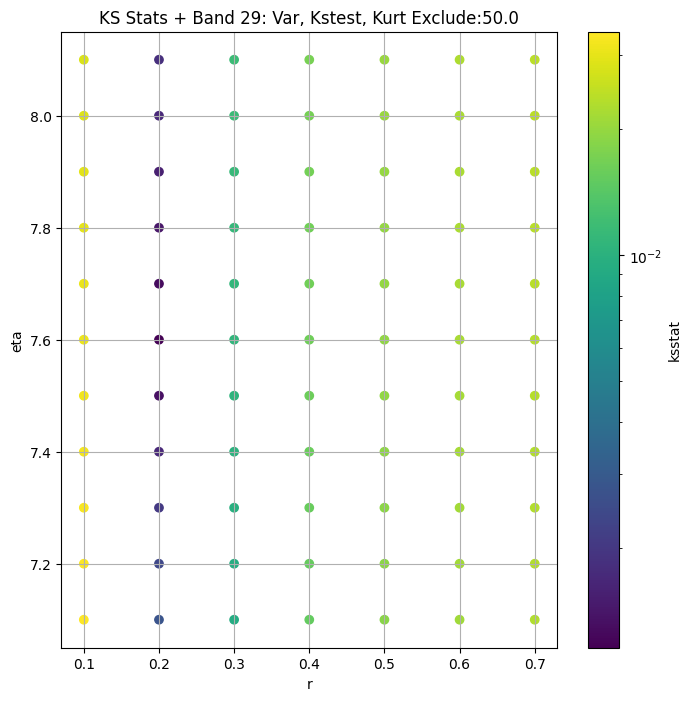

####
Band  32


100%|██████████| 12760/12760 [00:43<00:00, 293.43it/s]


Finding Minimum after computing 12760 CDFs
32 0 0.0016814658846457942 0.0027146097


100%|██████████| 12760/12760 [00:43<00:00, 294.90it/s]


Finding Minimum after computing 12760 CDFs
32 25 0.0016731383565037339 0.002675902


100%|██████████| 12760/12760 [00:42<00:00, 300.29it/s]


Finding Minimum after computing 12760 CDFs
32 50 0.0015882524544358345 0.0026496225


100%|██████████| 12760/12760 [00:42<00:00, 301.51it/s]


Finding Minimum after computing 12760 CDFs
32 75 0.0018211434089212553 0.002627231


100%|██████████| 12760/12760 [00:44<00:00, 283.70it/s]


Finding Minimum after computing 12760 CDFs
32 100 0.0021877433369559274 0.0026071486


100%|██████████| 12760/12760 [00:42<00:00, 303.73it/s]


Finding Minimum after computing 12760 CDFs
32 150 0.002853945033454486 0.0025709737


100%|██████████| 12760/12760 [00:41<00:00, 310.21it/s]


Finding Minimum after computing 12760 CDFs
32 200 0.003461256223225795 0.0025388137


100%|██████████| 12760/12760 [00:43<00:00, 293.35it/s]


Finding Minimum after computing 12760 CDFs
32 250 0.004042583431626778 0.0025095497


100%|██████████| 12760/12760 [00:41<00:00, 304.20it/s]


Finding Minimum after computing 12760 CDFs
32 300 0.004606938456745868 0.0024823698


100%|██████████| 12760/12760 [00:44<00:00, 288.48it/s]


Finding Minimum after computing 12760 CDFs
32 350 0.005142715021133282 0.0024569011


100%|██████████| 12760/12760 [00:45<00:00, 280.58it/s]


Finding Minimum after computing 12760 CDFs
32 500 0.006938690266145242 0.002388077
Number of samples: 100000, Without approximation : 419760.0


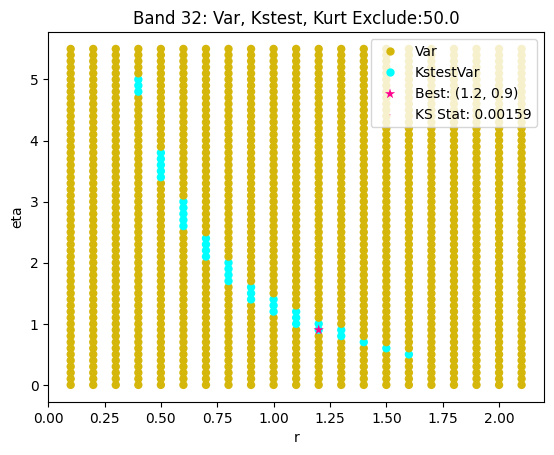

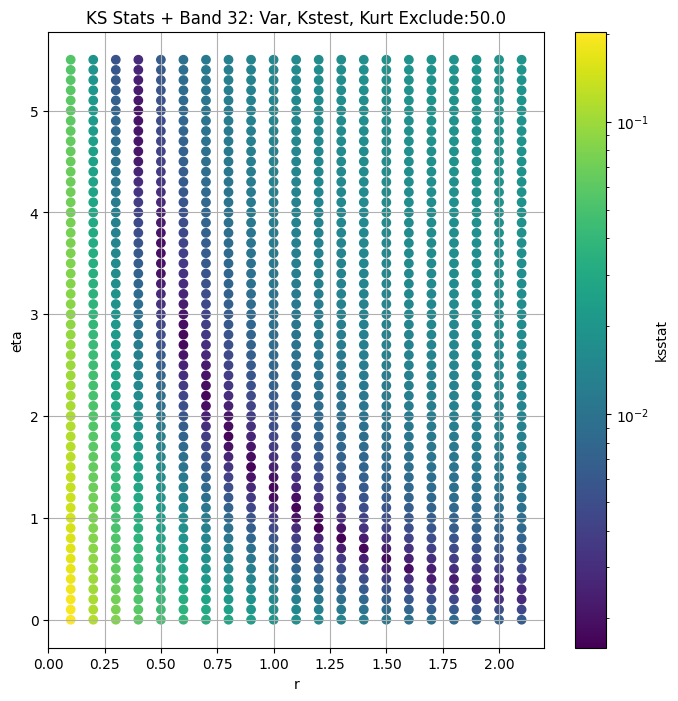

obs_var  var_lower  var_upper   obs_kurt  kurt_lower  kurt_upper  \
band                                                                      
2     9.598991   9.110358  10.110742   2.019593    1.471349    2.704436   
5     5.091696   4.837473   5.358150   1.903983    1.275784    2.832162   
8     2.783870   2.644551   2.927817   1.937604    1.312301    2.837549   
11    1.574336   1.491815   1.662111   2.370253    1.365877    4.514517   
14    0.857636   0.814612   0.903813   2.089291    1.275146    4.009901   
17    0.483346   0.458738   0.509555   2.151878    1.293355    4.513294   
20    0.247357   0.234671   0.261674   2.416864    1.276760    9.097979   
23    0.120827   0.114650   0.127477   2.248149    1.370794    4.596758   
26    0.052979   0.049797   0.057025   4.653831    1.694718   18.998148   
29    0.020105   0.018494   0.022679  13.155254    2.838861   66.098460   
32    0.002715   0.002586   0.002847   1.459712    1.005672    2.262223   

      total_samples  kstest_stat_initial  initial_r  initial_eta  \
band                                                               
2           31800.0             0.003425        1.0          0.7   
5           41340.0             0.002262        0.2          8.4   
8           66780.0             0.003265        0.2          8.5   
11         104940.0             0.001649        0.2          9.3   
14         162180.0             0.002545        0.5          3.1   
17         257580.0             0.000928        0.5          2.7   
20         381600.0             0.000983        0.5          2.7   
23         610560.0             0.001120        0.2          8.2   
26         973080.0             0.000723        0.2          8.1   
29        1376940.0             0.001159        0.2          7.6   
32         419760.0             0.001588        1.2          0.9   

      initial_scale  initial_exclude_cutoff  best_augmented_var  \
band                                                              
2      4.195024e+00                    25.0            9.229053   
5      1.408139e-08                     0.0            5.091696   
8      7.335603e-09                     0.0            2.783870   
11     2.803179e-09                    25.0            1.541339   
14     8.968863e-03                    25.0            0.841638   
17     6.003235e-03                    25.0            0.474015   
20     3.073543e-03                    25.0            0.242687   
23     3.686045e-10                     0.0            0.120827   
26     1.648367e-10                    25.0            0.051408   
29     7.718027e-11                    50.0            0.018621   
32     1.536427e-03                    50.0            0.002650   

      kstest_stat_cutoff_0.05  
band                           
2                    0.007611  
5                    0.006675  
8                    0.005253  
11                   0.004191  
14                   0.003371  
17                   0.002675  
20                   0.002198  
23                   0.001738  
26                   0.001377  
29                   0.001157  
32                   0.002096

In [12]:
master_df_combo_path = Path(os.path.join(CWD, "CSVs", "master_df_combo.csv"))
rEtaKsstats_dict_path = Path(os.path.join(CWD, "cache", "rEtaKsstats_dict.pickle"))

rEtaKsstats_dict = dict()

if RERUN or not master_df_combo_path.exists():
    sorted_params = sorted(all_cdfs)
    ksstats_dict = dict()

    for i, group in enumerate(GROUPS): # TODO For quick testing purposes
        print(f"####\n{GROUP.capitalize()} ", group)
        sample = group_data_map[group]
        group_cdfs_df = all_cdfs_df.copy()
        master_df.loc[group, 'kstest_stat_initial'] = 1

        for j in range(len(EXCLUDE_CUTOFFS)):

            exclude_cutoff = EXCLUDE_CUTOFFS[j]
            exclude_cutoff = int(exclude_cutoff)

            if exclude_cutoff == 0:
                augmented_var = np.var(group_data_map[group]) 
            else:
                augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])
                if augmented_var == np.var(group_data_map[group]):
                    continue 
                
            group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
            ksstats, initial_param, min_stat = gridsearch(sample, all_cdfs, debug=True, scales=group_cdfs_df['scale'])
            augmented_var_df.loc[group, f"kstest_stat_{exclude_cutoff}"] = min_stat
            group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] = ksstats
            
            print(group, exclude_cutoff, min_stat, augmented_var)
            
            if (min_stat < master_df.loc[group, 'kstest_stat_initial']) and not np.isclose(min_stat, master_df.loc[group, 'kstest_stat_initial'], 1e-6):
                inital_min_stat = min_stat
                inital_best_param = initial_param
                master_df.loc[group, 'kstest_stat_initial'] = min_stat
                initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                master_df.loc[group, 'initial_r'], master_df.loc[group, 'initial_eta'] = initial_param
                master_df.loc[group, 'initial_scale'] = initial_scale
                master_df.loc[group, 'initial_exclude_cutoff'] = exclude_cutoff
                master_df.loc[group, 'best_augmented_var'] = augmented_var
        
        ksstats = group_cdfs_df[f"ksstat_exclude_{int(master_df.loc[group, 'initial_exclude_cutoff'])}"]
            
        print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
        
        cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
        master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

        best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

        group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
        group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

        group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

        group_dict = {'r' : group_cdfs_df['r'], 'eta' : group_cdfs_df['eta']}
        group_dict.update({f'ksstat_exclude_{exclude_cutoff}' : group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] for exclude_cutoff in EXCLUDE_CUTOFFS[:j+1]})
        rEtaKsstats_dict[group] = group_dict

        cols = ['pass_var', 'pass_kstest', 'pass_kurt']

        fig = combo_test_plot(group_cdfs_df, cols, 
                            plot_name=f"{GROUP.capitalize()} {group}: {', '.join([col[5:].capitalize() for col in cols])} Exclude:{master_df.loc[group, 'initial_exclude_cutoff']}", 
                            target_var = None,
                            best_param = inital_best_param,
                            best_ksstat=inital_min_stat
                            )
        
        fig.figure.savefig(os.path.join(CWD, "plots", f"full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)

        # Optional: 
        # Create plots of bootstrapped variance and kurtosis for varying confidence intervals
        # fig_var = create_ci_scatter_plot(group_cdfs_df, var_values_dict, metric='variance', group=group)
        # fig_kurt = create_ci_scatter_plot(group_cdfs_df, kurt_values_dict, metric='kurtosis', group=group)

        # fig_var.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_var)
        # fig_kurt.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_kurt)

    master_df.to_csv(master_df_combo_path)
    pd.to_pickle(rEtaKsstats_dict, rEtaKsstats_dict_path)
    augmented_var_df.to_csv(augmented_var_df_path)

augmented_var_df = pd.read_csv(augmented_var_df_path, index_col=GROUP)
master_df = pd.read_csv(master_df_combo_path, index_col=GROUP)
rEtaKsstats_dict = pd.read_pickle(rEtaKsstats_dict_path)
master_df

## Optimization

In [13]:
master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
master_df[f'best_r'] = master_df['initial_r']
master_df[f'best_eta'] = master_df['initial_eta']
master_df[f'best_scale'] = master_df['initial_scale']
master_df[f'best_exclude_cutoff'] = master_df['initial_exclude_cutoff']

Band 2


100%|██████████| 990/990 [00:01<00:00, 710.94it/s]


Finding Minimum after computing 990 CDFs
band 2, 25.0 + 100 = 125, ksstat: 0.007047744672891598, var: 8.476290702819824


100%|██████████| 990/990 [00:01<00:00, 840.56it/s]


Finding Minimum after computing 990 CDFs
band 2, 25.0 + 75 = 100, ksstat: 0.0058895880578088144, var: 8.628830909729004


100%|██████████| 990/990 [00:01<00:00, 833.77it/s]


Finding Minimum after computing 990 CDFs
band 2, 25.0 + 50 = 75, ksstat: 0.004920142460812182, var: 8.795794486999512


100%|██████████| 990/990 [00:01<00:00, 938.96it/s]


Finding Minimum after computing 990 CDFs
band 2, 25.0 + 25 = 50, ksstat: 0.0037786025399342282, var: 8.988859176635742


100%|██████████| 990/990 [00:01<00:00, 937.10it/s]


Finding Minimum after computing 990 CDFs
band 2, 25.0 + 0 = 25, ksstat: 0.0033613557913695358, var: 9.229053497314453


100%|██████████| 990/990 [00:01<00:00, 874.29it/s]


Finding Minimum after computing 990 CDFs
band 2, 25.0 + -25 = 0, ksstat: 0.003692987270967729, var: 9.598991394042969
Number of samples: 31800, Without approximation : 31800.0


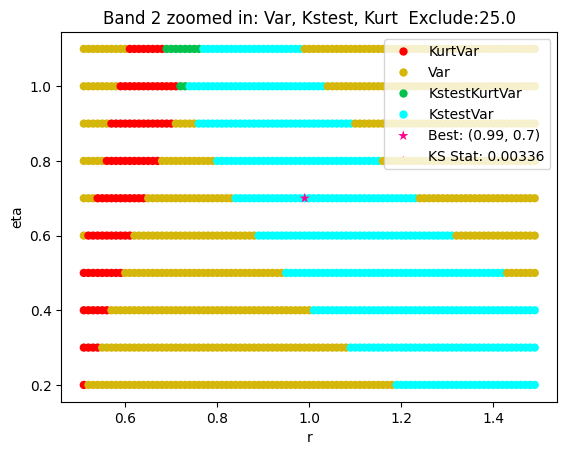

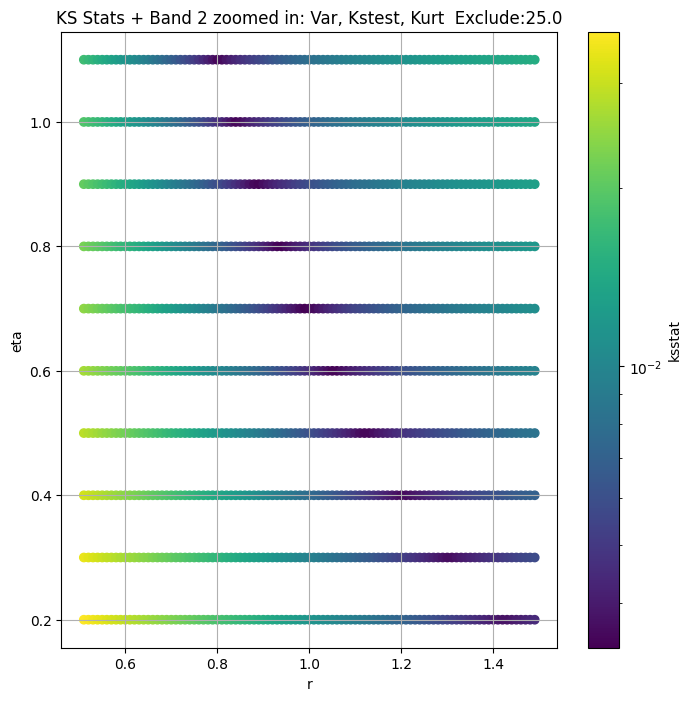

Band 5


100%|██████████| 621/621 [00:01<00:00, 587.39it/s]


Finding Minimum after computing 621 CDFs
band 5, 0.0 + 100 = 100, ksstat: 0.005351870985966456, var: 4.675750255584717


100%|██████████| 621/621 [00:01<00:00, 531.39it/s]


Finding Minimum after computing 621 CDFs
band 5, 0.0 + 75 = 75, ksstat: 0.004454450567657142, var: 4.747922420501709


100%|██████████| 621/621 [00:00<00:00, 704.75it/s]


Finding Minimum after computing 621 CDFs
band 5, 0.0 + 50 = 50, ksstat: 0.003477596028984009, var: 4.830058574676514


100%|██████████| 621/621 [00:00<00:00, 712.25it/s]


Finding Minimum after computing 621 CDFs
band 5, 0.0 + 25 = 25, ksstat: 0.0024650813762113755, var: 4.928395748138428


100%|██████████| 621/621 [00:00<00:00, 729.47it/s]


Finding Minimum after computing 621 CDFs
band 5, 0.0 + 0 = 0, ksstat: 0.0022623140546526033, var: 5.091696262359619
Number of samples: 41340, Without approximation : 41340.0


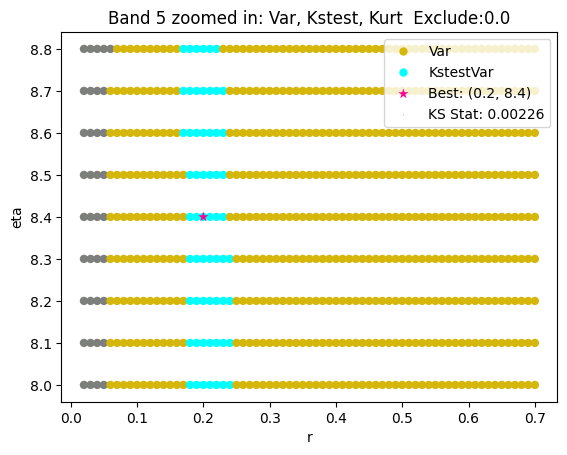

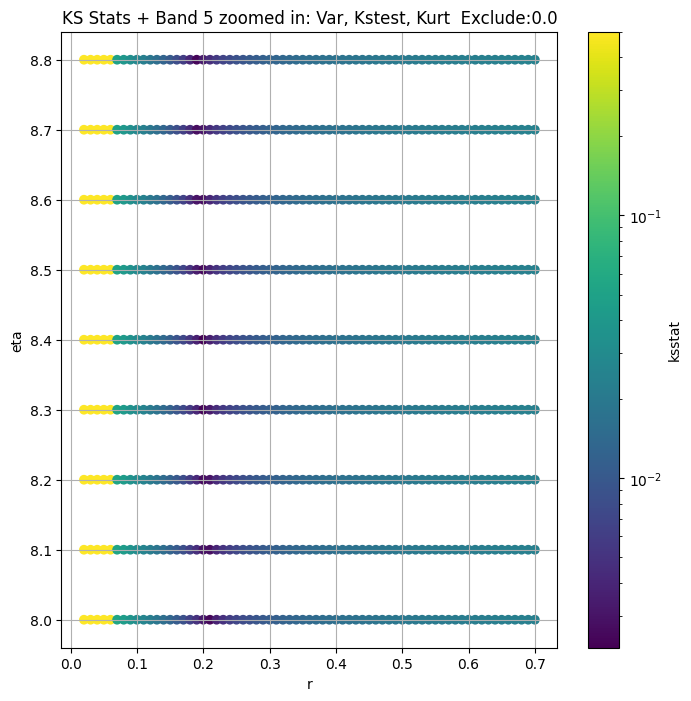

Band 8


100%|██████████| 621/621 [00:01<00:00, 435.26it/s]


Finding Minimum after computing 621 CDFs
band 8, 0.0 + 100 = 100, ksstat: 0.0043062451074216135, var: 2.6170647144317627


100%|██████████| 621/621 [00:01<00:00, 453.84it/s]


Finding Minimum after computing 621 CDFs
band 8, 0.0 + 75 = 75, ksstat: 0.0036578006304730515, var: 2.647512197494507


100%|██████████| 621/621 [00:01<00:00, 429.14it/s]


Finding Minimum after computing 621 CDFs
band 8, 0.0 + 50 = 50, ksstat: 0.0032594193749215794, var: 2.6811511516571045


100%|██████████| 621/621 [00:01<00:00, 462.54it/s]


Finding Minimum after computing 621 CDFs
band 8, 0.0 + 25 = 25, ksstat: 0.0032673169205040264, var: 2.7202117443084717


100%|██████████| 621/621 [00:01<00:00, 463.45it/s]


Finding Minimum after computing 621 CDFs
band 8, 0.0 + 0 = 0, ksstat: 0.0032650376270186854, var: 2.783869981765747
Number of samples: 66780, Without approximation : 66780.0


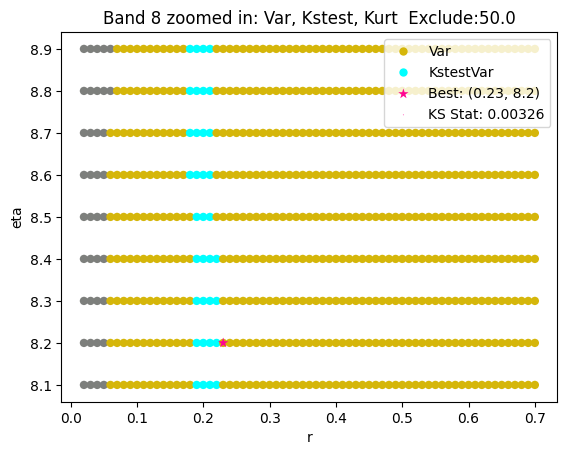

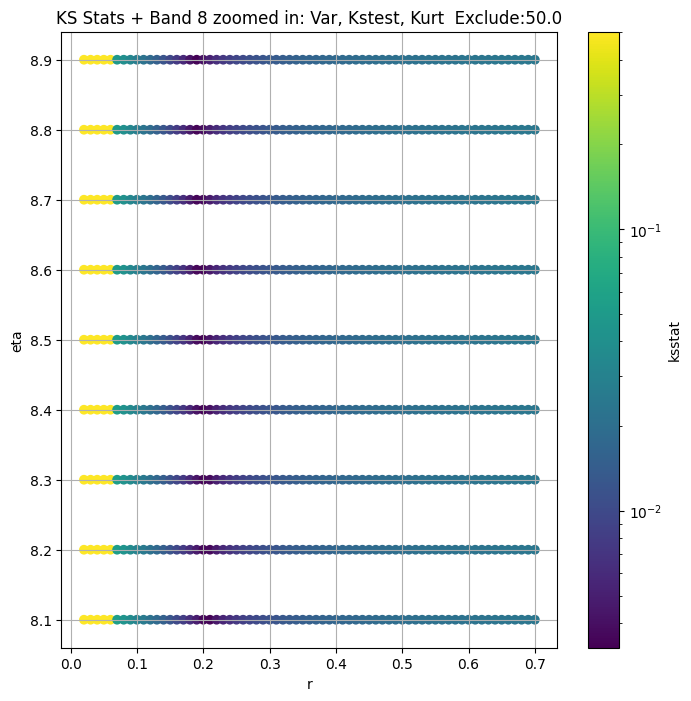

Band 11


100%|██████████| 621/621 [00:02<00:00, 262.21it/s]


Finding Minimum after computing 621 CDFs
band 11, 25.0 + 100 = 125, ksstat: 0.003063280903635668, var: 1.4821650981903076


100%|██████████| 621/621 [00:01<00:00, 311.33it/s]


Finding Minimum after computing 621 CDFs
band 11, 25.0 + 75 = 100, ksstat: 0.002669762410335841, var: 1.4942400455474854


100%|██████████| 621/621 [00:02<00:00, 299.17it/s]


Finding Minimum after computing 621 CDFs
band 11, 25.0 + 50 = 75, ksstat: 0.0022621418706309515, var: 1.507714033126831


100%|██████████| 621/621 [00:02<00:00, 290.13it/s]


Finding Minimum after computing 621 CDFs
band 11, 25.0 + 25 = 50, ksstat: 0.0018371315792239384, var: 1.5230669975280762


100%|██████████| 621/621 [00:02<00:00, 274.29it/s]


Finding Minimum after computing 621 CDFs
band 11, 25.0 + 0 = 25, ksstat: 0.0016488965219491614, var: 1.5413389205932617


100%|██████████| 621/621 [00:02<00:00, 305.93it/s]


Finding Minimum after computing 621 CDFs
band 11, 25.0 + -25 = 0, ksstat: 0.0016967880437641636, var: 1.574336051940918
Number of samples: 100000, Without approximation : 104940.0


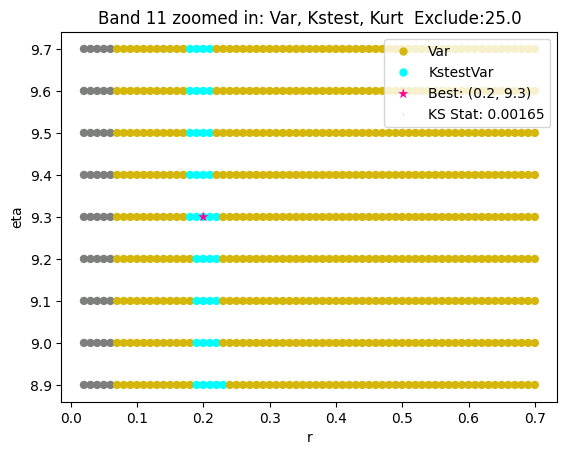

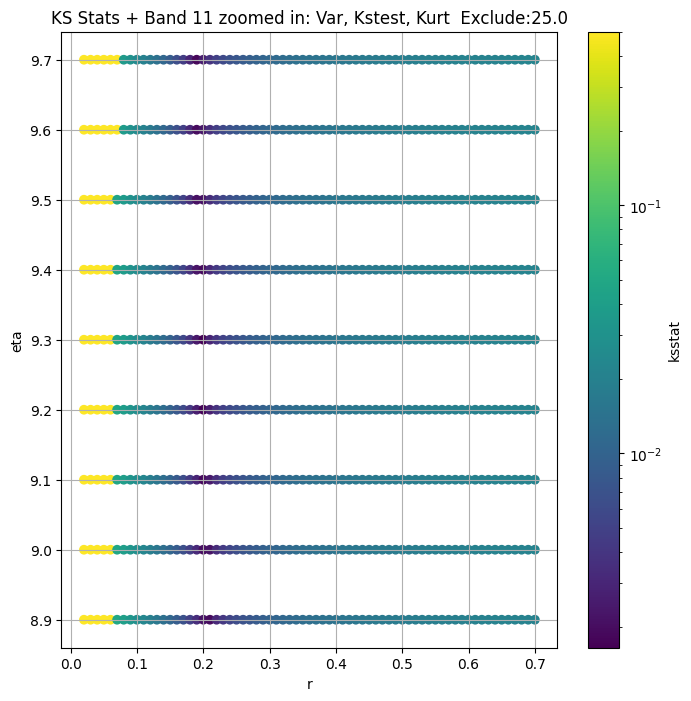

Band 14


100%|██████████| 882/882 [00:03<00:00, 272.51it/s]


Finding Minimum after computing 882 CDFs
band 14, 25.0 + 100 = 125, ksstat: 0.0026435269326723423, var: 0.8108544945716858


100%|██████████| 882/882 [00:02<00:00, 311.50it/s]


Finding Minimum after computing 882 CDFs
band 14, 25.0 + 75 = 100, ksstat: 0.002550618347698208, var: 0.8172912001609802


100%|██████████| 882/882 [00:02<00:00, 307.88it/s]


Finding Minimum after computing 882 CDFs
band 14, 25.0 + 50 = 75, ksstat: 0.0025490546658735735, var: 0.8243390321731567


100%|██████████| 882/882 [00:02<00:00, 309.99it/s]


Finding Minimum after computing 882 CDFs
band 14, 25.0 + 25 = 50, ksstat: 0.002567927712333662, var: 0.8322287797927856


100%|██████████| 882/882 [00:02<00:00, 297.84it/s]


Finding Minimum after computing 882 CDFs
band 14, 25.0 + 0 = 25, ksstat: 0.002545224309894567, var: 0.8416381478309631


100%|██████████| 882/882 [00:03<00:00, 289.07it/s]


Finding Minimum after computing 882 CDFs
band 14, 25.0 + -25 = 0, ksstat: 0.0027416331619836976, var: 0.8576356172561646
Number of samples: 100000, Without approximation : 162180.0


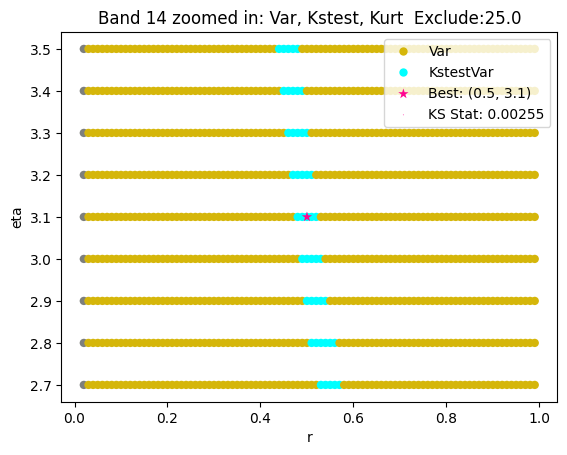

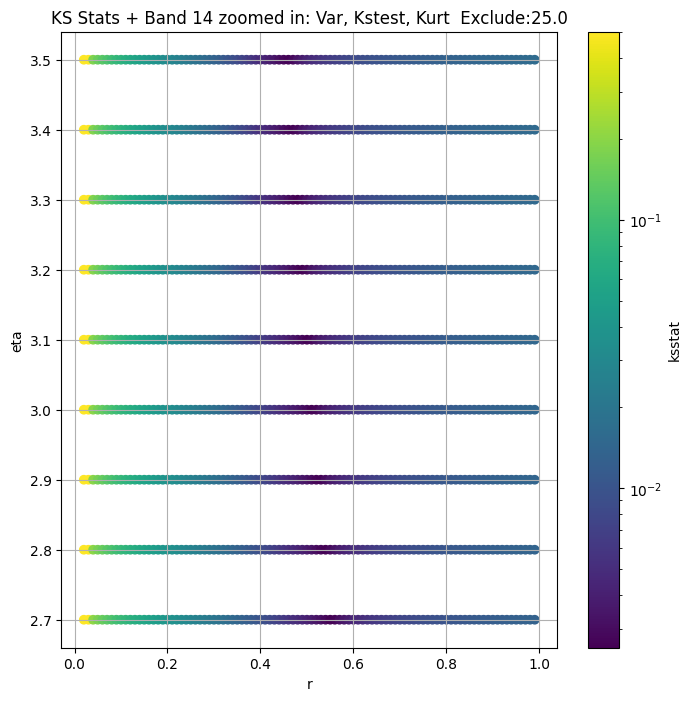

Band 17


100%|██████████| 882/882 [00:03<00:00, 289.41it/s]


Finding Minimum after computing 882 CDFs
band 17, 25.0 + 100 = 125, ksstat: 0.002915847945576422, var: 0.45671045780181885


100%|██████████| 882/882 [00:02<00:00, 310.13it/s]


Finding Minimum after computing 882 CDFs
band 17, 25.0 + 75 = 100, ksstat: 0.002465359111895493, var: 0.4602832496166229


100%|██████████| 882/882 [00:02<00:00, 304.97it/s]


Finding Minimum after computing 882 CDFs
band 17, 25.0 + 50 = 75, ksstat: 0.0019748617280931358, var: 0.4642338156700134


100%|██████████| 882/882 [00:02<00:00, 303.79it/s]


Finding Minimum after computing 882 CDFs
band 17, 25.0 + 25 = 50, ksstat: 0.0014334702815195222, var: 0.46866658329963684


100%|██████████| 882/882 [00:02<00:00, 307.08it/s]


Finding Minimum after computing 882 CDFs
band 17, 25.0 + 0 = 25, ksstat: 0.000928131609215177, var: 0.474015474319458


100%|██████████| 882/882 [00:02<00:00, 311.37it/s]


Finding Minimum after computing 882 CDFs
band 17, 25.0 + -25 = 0, ksstat: 0.0012826072972124333, var: 0.4833461046218872
Number of samples: 100000, Without approximation : 257580.0


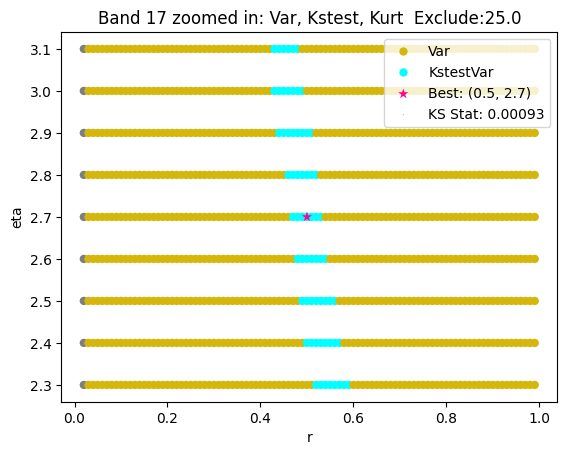

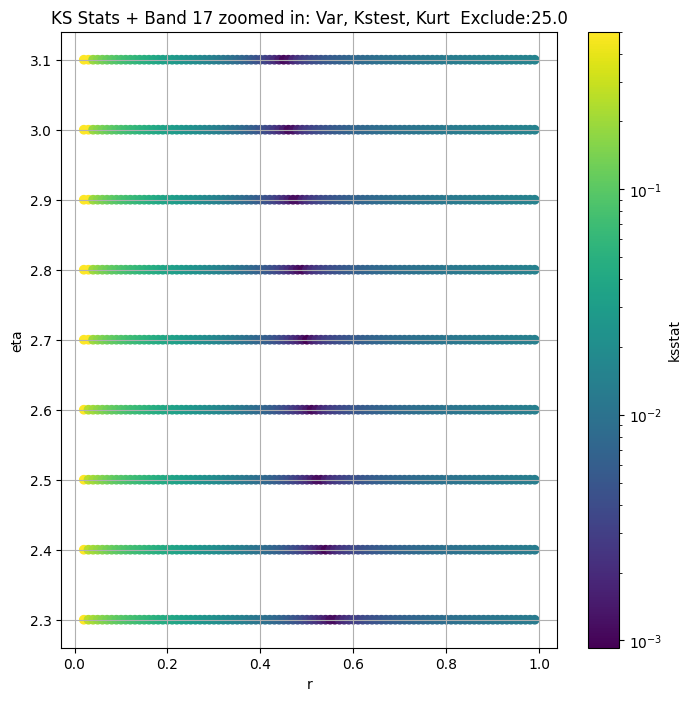

Band 20


100%|██████████| 882/882 [00:02<00:00, 310.41it/s]


Finding Minimum after computing 882 CDFs
band 20, 25.0 + 100 = 125, ksstat: 0.002657735553598259, var: 0.23391510546207428


100%|██████████| 882/882 [00:02<00:00, 305.07it/s]


Finding Minimum after computing 882 CDFs
band 20, 25.0 + 75 = 100, ksstat: 0.00218802343426535, var: 0.2357650250196457


100%|██████████| 882/882 [00:02<00:00, 305.05it/s]


Finding Minimum after computing 882 CDFs
band 20, 25.0 + 50 = 75, ksstat: 0.0016981684420667442, var: 0.23778167366981506


100%|██████████| 882/882 [00:02<00:00, 307.25it/s]


Finding Minimum after computing 882 CDFs
band 20, 25.0 + 25 = 50, ksstat: 0.001215884489213559, var: 0.24004164338111877


100%|██████████| 882/882 [00:02<00:00, 307.16it/s]


Finding Minimum after computing 882 CDFs
band 20, 25.0 + 0 = 25, ksstat: 0.0009326647679354094, var: 0.24268697202205658


100%|██████████| 882/882 [00:02<00:00, 307.91it/s]


Finding Minimum after computing 882 CDFs
band 20, 25.0 + -25 = 0, ksstat: 0.0013277148925968651, var: 0.24735701084136963
Number of samples: 100000, Without approximation : 381600.0


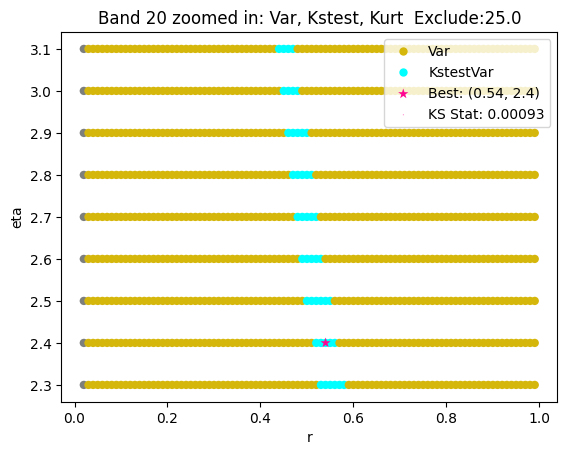

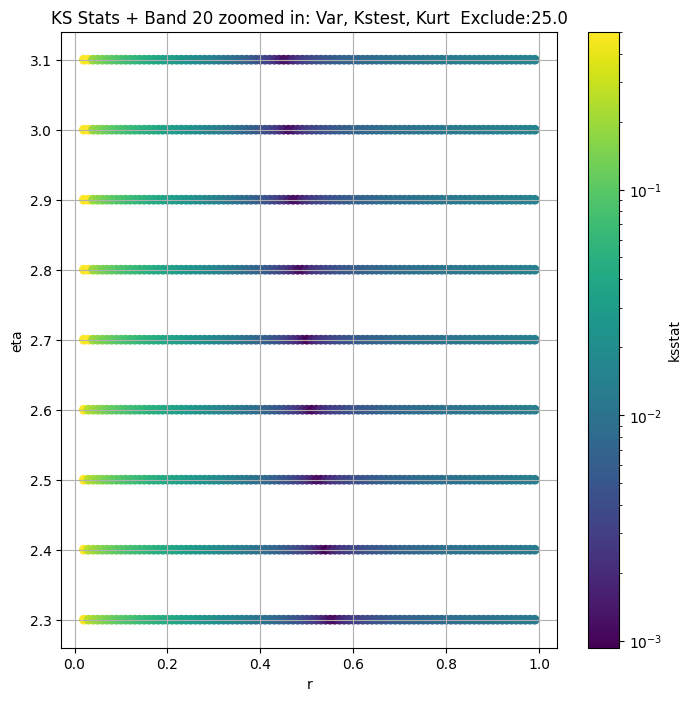

Band 23


100%|██████████| 690/690 [00:02<00:00, 294.38it/s]


Finding Minimum after computing 690 CDFs
band 23, 0.0 + 100 = 100, ksstat: 0.0023051150440246415, var: 0.11496134847402573


100%|██████████| 690/690 [00:02<00:00, 295.61it/s]


Finding Minimum after computing 690 CDFs
band 23, 0.0 + 75 = 75, ksstat: 0.0018202514024393546, var: 0.11597315222024918


100%|██████████| 690/690 [00:02<00:00, 309.47it/s]


Finding Minimum after computing 690 CDFs
band 23, 0.0 + 50 = 50, ksstat: 0.0013558726786050412, var: 0.11711236834526062


100%|██████████| 690/690 [00:02<00:00, 306.71it/s]


Finding Minimum after computing 690 CDFs
band 23, 0.0 + 25 = 25, ksstat: 0.0011766957860487315, var: 0.11848437041044235


100%|██████████| 690/690 [00:02<00:00, 259.00it/s]


Finding Minimum after computing 690 CDFs
band 23, 0.0 + 0 = 0, ksstat: 0.0011203195272457556, var: 0.12082742154598236
Number of samples: 100000, Without approximation : 610560.0


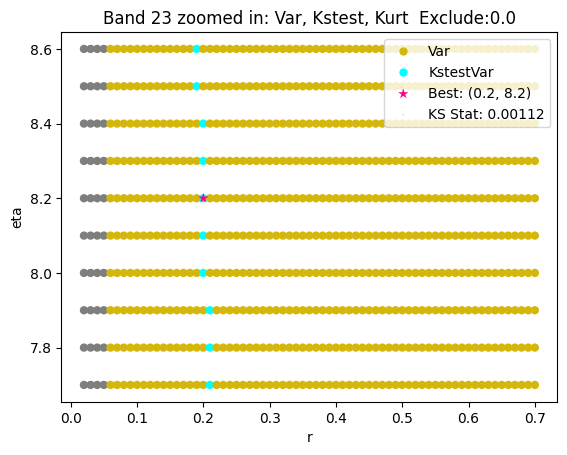

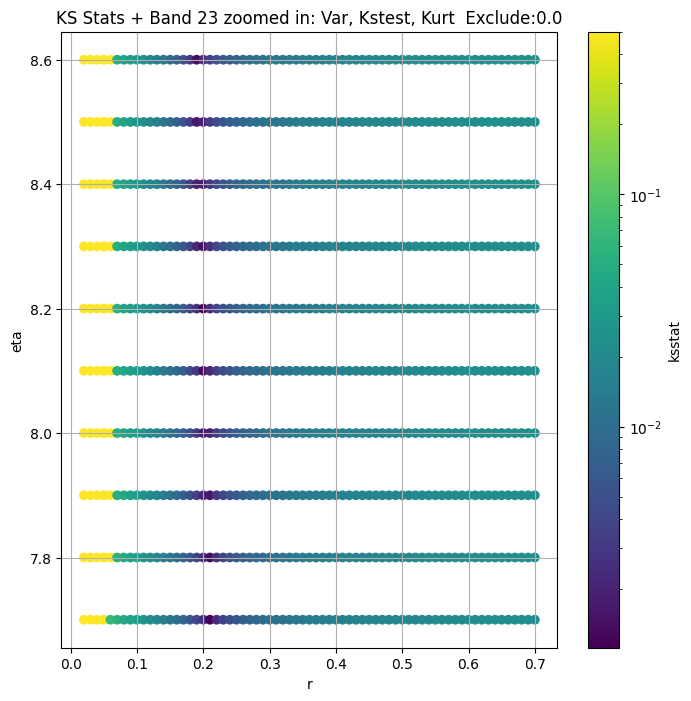

Band 26


100%|██████████| 621/621 [00:02<00:00, 257.08it/s]


Finding Minimum after computing 621 CDFs
band 26, 25.0 + 100 = 125, ksstat: 0.0024886513962761904, var: 0.049178000539541245


100%|██████████| 621/621 [00:02<00:00, 306.90it/s]


Finding Minimum after computing 621 CDFs
band 26, 25.0 + 75 = 100, ksstat: 0.0019972120407564103, var: 0.04961741715669632


100%|██████████| 621/621 [00:02<00:00, 295.23it/s]


Finding Minimum after computing 621 CDFs
band 26, 25.0 + 50 = 75, ksstat: 0.0014591709533548873, var: 0.0501091368496418


100%|██████████| 621/621 [00:02<00:00, 303.71it/s]


Finding Minimum after computing 621 CDFs
band 26, 25.0 + 25 = 50, ksstat: 0.0008994265435500193, var: 0.050683047622442245


100%|██████████| 621/621 [00:02<00:00, 296.94it/s]


Finding Minimum after computing 621 CDFs
band 26, 25.0 + 0 = 25, ksstat: 0.0007234453993844037, var: 0.05140848830342293


100%|██████████| 621/621 [00:02<00:00, 302.50it/s]


Finding Minimum after computing 621 CDFs
band 26, 25.0 + -25 = 0, ksstat: 0.0018673663212634972, var: 0.05297881364822388
Number of samples: 100000, Without approximation : 973080.0


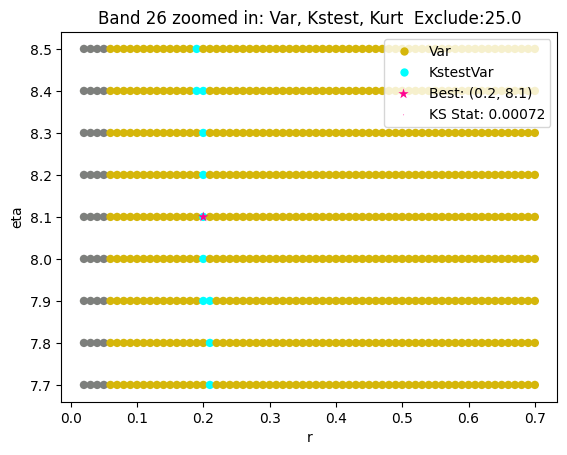

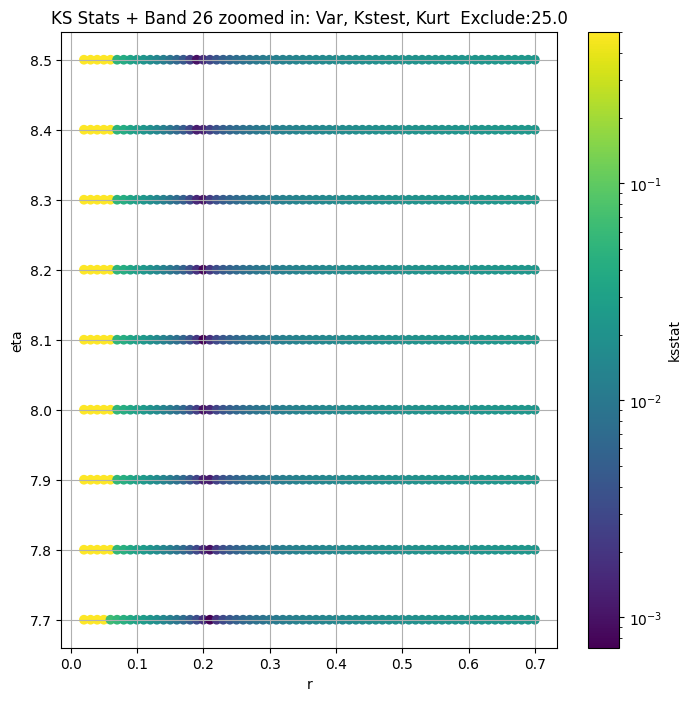

Band 29


100%|██████████| 621/621 [00:02<00:00, 286.08it/s]


Finding Minimum after computing 621 CDFs
band 29, 50.0 + 100 = 150, ksstat: 0.0020135766379056896, var: 0.017711928114295006


100%|██████████| 621/621 [00:02<00:00, 306.00it/s]


Finding Minimum after computing 621 CDFs
band 29, 50.0 + 75 = 125, ksstat: 0.0016693907560811905, var: 0.017891153693199158


100%|██████████| 621/621 [00:02<00:00, 276.46it/s]


Finding Minimum after computing 621 CDFs
band 29, 50.0 + 50 = 100, ksstat: 0.001385377780955377, var: 0.01809282973408699


100%|██████████| 621/621 [00:02<00:00, 294.62it/s]


Finding Minimum after computing 621 CDFs
band 29, 50.0 + 25 = 75, ksstat: 0.0011608380986497524, var: 0.018328431993722916


100%|██████████| 621/621 [00:02<00:00, 307.53it/s]


Finding Minimum after computing 621 CDFs
band 29, 50.0 + 0 = 50, ksstat: 0.0011594876442090202, var: 0.018621351569890976


100%|██████████| 621/621 [00:01<00:00, 310.97it/s]


Finding Minimum after computing 621 CDFs
band 29, 50.0 + -25 = 25, ksstat: 0.002143644797127163, var: 0.019032863900065422


100%|██████████| 621/621 [00:02<00:00, 298.39it/s]


Finding Minimum after computing 621 CDFs
band 29, 50.0 + -50 = 0, ksstat: 0.00478586072826525, var: 0.02010464295744896
Number of samples: 100000, Without approximation : 1376940.0


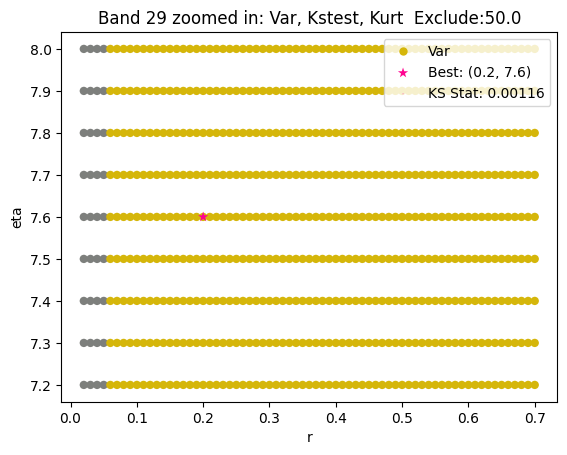

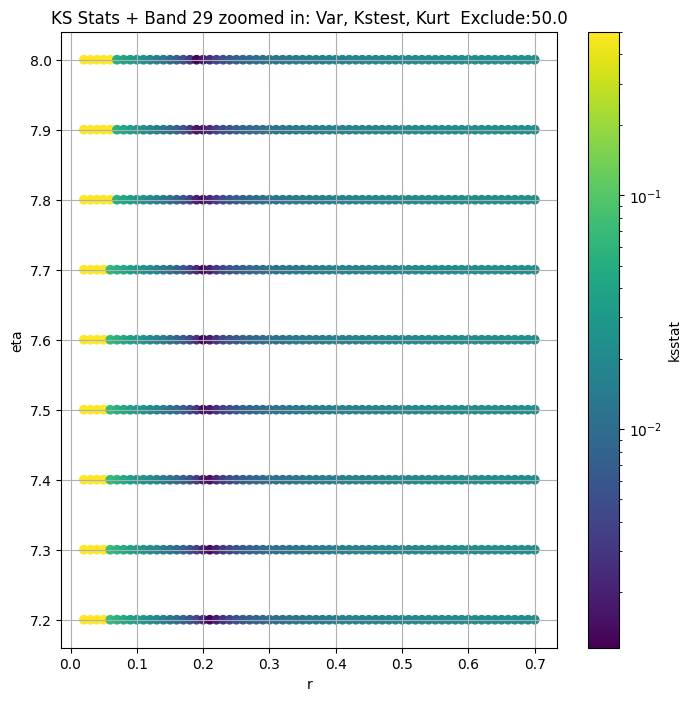

Band 32


100%|██████████| 990/990 [00:04<00:00, 235.50it/s]


Finding Minimum after computing 990 CDFs
band 32, 50.0 + 100 = 150, ksstat: 0.0028570395568432994, var: 0.0025709737092256546


100%|██████████| 990/990 [00:03<00:00, 288.12it/s]


Finding Minimum after computing 990 CDFs
band 32, 50.0 + 75 = 125, ksstat: 0.0025018900971700564, var: 0.002588501665741205


100%|██████████| 990/990 [00:03<00:00, 274.71it/s]


Finding Minimum after computing 990 CDFs
band 32, 50.0 + 50 = 100, ksstat: 0.002144543531992338, var: 0.0026071486063301563


100%|██████████| 990/990 [00:03<00:00, 305.99it/s]


Finding Minimum after computing 990 CDFs
band 32, 50.0 + 25 = 75, ksstat: 0.0017999621381847852, var: 0.0026272309478372335


100%|██████████| 990/990 [00:03<00:00, 311.11it/s]


Finding Minimum after computing 990 CDFs
band 32, 50.0 + 0 = 50, ksstat: 0.0015718773115930285, var: 0.00264962250366807


100%|██████████| 990/990 [00:03<00:00, 311.48it/s]


Finding Minimum after computing 990 CDFs
band 32, 50.0 + -25 = 25, ksstat: 0.0016153804045080378, var: 0.002675902098417282


100%|██████████| 990/990 [00:03<00:00, 311.47it/s]


Finding Minimum after computing 990 CDFs
band 32, 50.0 + -50 = 0, ksstat: 0.0020235347785076963, var: 0.0027146097272634506
Number of samples: 100000, Without approximation : 419760.0


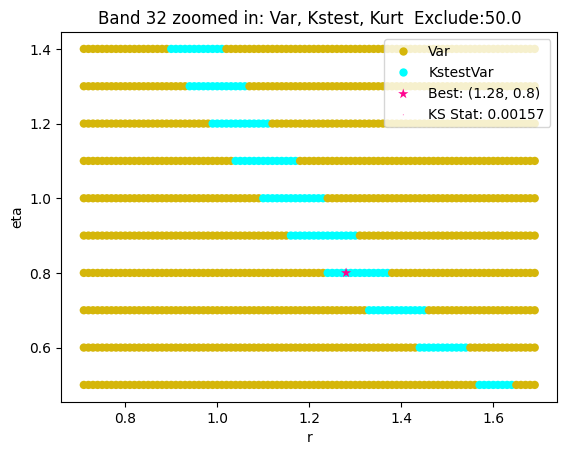

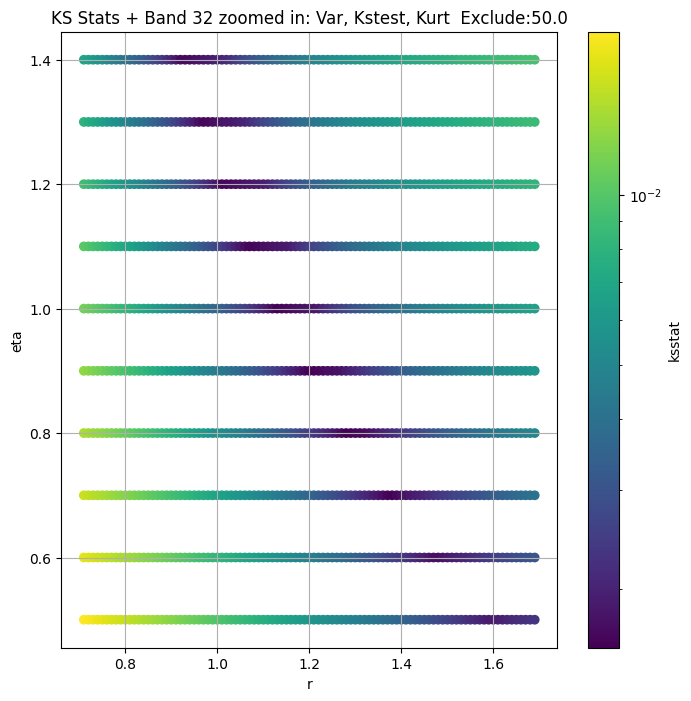

obs_var  var_lower  var_upper   obs_kurt  kurt_lower  kurt_upper  \
band                                                                      
2     9.598991   9.110358  10.110742   2.019593    1.471349    2.704436   
5     5.091696   4.837473   5.358150   1.903983    1.275784    2.832162   
8     2.783870   2.644551   2.927817   1.937604    1.312301    2.837549   
11    1.574336   1.491815   1.662111   2.370253    1.365877    4.514517   
14    0.857636   0.814612   0.903813   2.089291    1.275146    4.009901   
17    0.483346   0.458738   0.509555   2.151878    1.293355    4.513294   
20    0.247357   0.234671   0.261674   2.416864    1.276760    9.097979   
23    0.120827   0.114650   0.127477   2.248149    1.370794    4.596758   
26    0.052979   0.049797   0.057025   4.653831    1.694718   18.998148   
29    0.020105   0.018494   0.022679  13.155254    2.838861   66.098460   
32    0.002715   0.002586   0.002847   1.459712    1.005672    2.262223   

      total_samples  kstest_stat_initial  initial_r  initial_eta  \
band                                                               
2           31800.0             0.003425        1.0          0.7   
5           41340.0             0.002262        0.2          8.4   
8           66780.0             0.003265        0.2          8.5   
11         104940.0             0.001649        0.2          9.3   
14         162180.0             0.002545        0.5          3.1   
17         257580.0             0.000928        0.5          2.7   
20         381600.0             0.000983        0.5          2.7   
23         610560.0             0.001120        0.2          8.2   
26         973080.0             0.000723        0.2          8.1   
29        1376940.0             0.001159        0.2          7.6   
32         419760.0             0.001588        1.2          0.9   

      initial_scale  initial_exclude_cutoff  best_augmented_var  \
band                                                              
2      4.195024e+00                    25.0            9.229053   
5      1.408139e-08                     0.0            5.091696   
8      7.335603e-09                     0.0            2.681151   
11     2.803179e-09                    25.0            1.541339   
14     8.968863e-03                    25.0            0.841638   
17     6.003235e-03                    25.0            0.474015   
20     3.073543e-03                    25.0            0.242687   
23     3.686045e-10                     0.0            0.120827   
26     1.648367e-10                    25.0            0.051408   
29     7.718027e-11                    50.0            0.018621   
32     1.536427e-03                    50.0            0.002650   

      kstest_stat_cutoff_0.05  kstest_stat_best  best_r  best_eta  \
band                                                                
2                    0.007611          0.003361    0.99       0.7   
5                    0.006675          0.002262    0.20       8.4   
8                    0.005253          0.003259    0.23       8.2   
11                   0.004191          0.001649    0.20       9.3   
14                   0.003371          0.002545    0.50       3.1   
17                   0.002675          0.000928    0.50       2.7   
20                   0.002198          0.000933    0.54       2.4   
23                   0.001738          0.001120    0.20       8.2   
26                   0.001377          0.000723    0.20       8.1   
29                   0.001157          0.001159    0.20       7.6   
32                   0.002096          0.001572    1.28       0.8   

        best_scale  best_exclude_cutoff  n_pval_0.05  
band                                                  
2     4.110970e+00                 25.0     160987.0  
5     1.408139e-08                  0.0     353164.0  
8     1.950517e-07                 50.0     169036.0  
11    2.803179e-09                 25.0     672372.0  
14    8.968863e-03                 25.0     27

In [14]:
master_df_optimized_path = Path(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))

NUM_ITERS = dict(zip(GROUPS, [1]*len(GROUPS))) # By default, does one iteration per group
NUM_SAMPLES_OPTIMIZE = 2000
EXCLUDE_CUTOFFS_OPTIMIZE = np.arange(100, -101, -25)

if RERUN or not master_df_optimized_path.exists():

    if SKIP_OPTIMIZE_STEP:

        master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
        master_df[f'best_r'] = master_df['initial_r']
        master_df[f'best_eta'] = master_df['initial_eta']
        master_df[f'best_scale'] = master_df['initial_scale']
        master_df[f'best_exclude_cutoff'] = master_df['initial_exclude_cutoff']

    else:
        for group in GROUPS: # TODO For quick testing purposes
            print(f"{GROUP.capitalize()} {group}")
            master_df.loc[group, 'kstest_stat_best'] = master_df.loc[group, 'kstest_stat_initial']
            master_df.loc[group, 'best_r'] = master_df.loc[group, 'initial_r']
            master_df.loc[group, 'best_eta'] = master_df.loc[group, 'initial_eta']
            master_df.loc[group, 'best_scale'] = master_df.loc[group, 'initial_scale']

            sample = group_data_map[group]
            initial_r, initial_eta = master_df.loc[group, 'initial_r'], master_df.loc[group, f'initial_eta']
            eps = 0.5
            group_cdfs_df = fine_cdfs_df[(np.abs(master_df.loc[group, 'initial_r'] - fine_cdfs_df['r']) < eps) & 
                                        (np.abs(master_df.loc[group, 'initial_eta'] - fine_cdfs_df['eta']) < eps)].reset_index(drop=True)
            group_cdfs = {x[0]:x[1] for x in group_cdfs_df['(r,eta),cdf']}

            for adjust_exclude_cutoff in EXCLUDE_CUTOFFS_OPTIMIZE: # -50, -25, 0, 25, 50
                
                exclude_cutoff = int(max(0, adjust_exclude_cutoff + master_df.loc[group, 'initial_exclude_cutoff']))
                
                if exclude_cutoff == 0:
                    augmented_var = np.var(group_data_map[group])
                else:
                    augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])                       

                group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
                ksstats, initial_param, min_stat = gridsearch(sample, group_cdfs, debug=True, scales=group_cdfs_df['scale'])
                
                cutoff_label = generate_cutoff_label(adjust_exclude_cutoff)

                augmented_var_df.loc[group, f"kstest_stat_{cutoff_label}"] = min_stat
                group_cdfs_df[f'ksstat_exclude_{cutoff_label}'] = ksstats
                
                print(f"{GROUP} {group}, {master_df.loc[group, 'initial_exclude_cutoff']} + {adjust_exclude_cutoff} = {exclude_cutoff}, ksstat: {min_stat}, var: {augmented_var}")
                best_adjust = 0

                if min_stat < master_df.loc[group, 'kstest_stat_best']:

                    inital_min_stat = min_stat
                    inital_best_param = initial_param
                    master_df.loc[group, 'kstest_stat_best'] = min_stat
                    initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                    master_df.loc[group, 'best_r'], master_df.loc[group, 'best_eta'] = initial_param
                    master_df.loc[group, 'best_scale'] = initial_scale
                    master_df.loc[group, 'best_exclude_cutoff'] = exclude_cutoff
                    master_df.loc[group, 'best_augmented_var'] = augmented_var
                    augmented_var_df.loc[group, 'best_augmented_var'] = augmented_var
                    best_adjust = adjust_exclude_cutoff

                if exclude_cutoff == 0:
                    break

            cutoff_label = generate_cutoff_label(best_adjust)
            ksstats = group_cdfs_df[f"ksstat_exclude_{cutoff_label}"]
            
            print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
            
            cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
            master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

            best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

            group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
            group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

            group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

            group_dict = rEtaKsstats_dict[group]
            group_dict.update({'r_optimize' : group_cdfs_df['r'], 'eta_optimize' : group_cdfs_df['eta'], f'ksstat_exclude_{cutoff_label}' : ksstats})
            rEtaKsstats_dict[group] = group_dict

            cols = ['pass_var', 'pass_kstest', 'pass_kurt']
            fig = combo_test_plot(group_cdfs_df, cols, 
                                plot_name=f"{GROUP.capitalize()} {group} zoomed in: {', '.join([col[5:].capitalize() for col in cols])}  Exclude:{master_df.loc[group, 'best_exclude_cutoff']}",
                                best_param=(master_df.loc[group, 'best_r'], master_df.loc[group, f'best_eta']),
                                best_ksstat=master_df.loc[group, 'kstest_stat_best'])
            fig.figure.savefig(os.path.join(CWD, "plots", f"optimized_full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)
            
    master_df['n_pval_0.05'] = master_df.apply(lambda row : find_n_fixed_pval_stat(row.loc['kstest_stat_best'], row.loc['total_samples']), axis = 1)    
    master_df[['total_samples', 'initial_r', 'initial_eta', 'kstest_stat_initial', 'initial_exclude_cutoff', 'best_r', 'best_eta', 'best_scale', 'kstest_stat_best', 'best_exclude_cutoff', 'n_pval_0.05']].to_csv(os.path.join(CWD, "CSVs", 'optimized_params.csv'))
    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))
    augmented_var_df.to_csv(augmented_var_df_path)
    pd.to_pickle(rEtaKsstats_dict, rEtaKsstats_dict_path)

rEtaKsstats_dict = pd.read_pickle(rEtaKsstats_dict_path)
master_df = pd.read_csv(master_df_optimized_path, index_col = GROUP)
augmented_var_df = pd.read_csv(augmented_var_df_path, index_col = GROUP)
master_df

## Comparing Empirical and Computed CDF/PDF

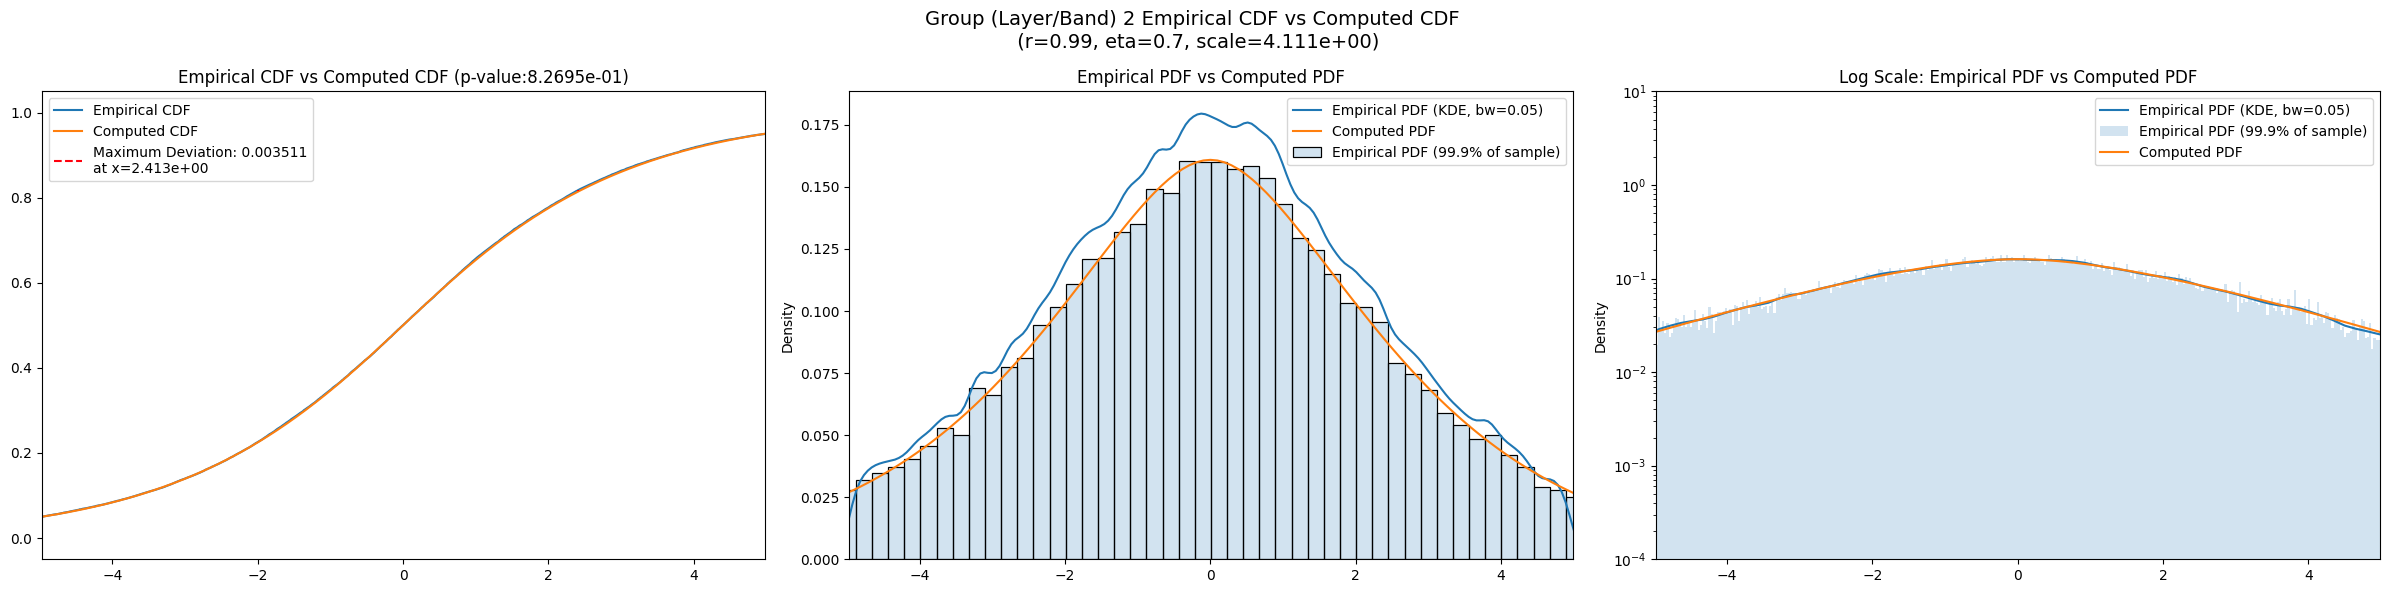

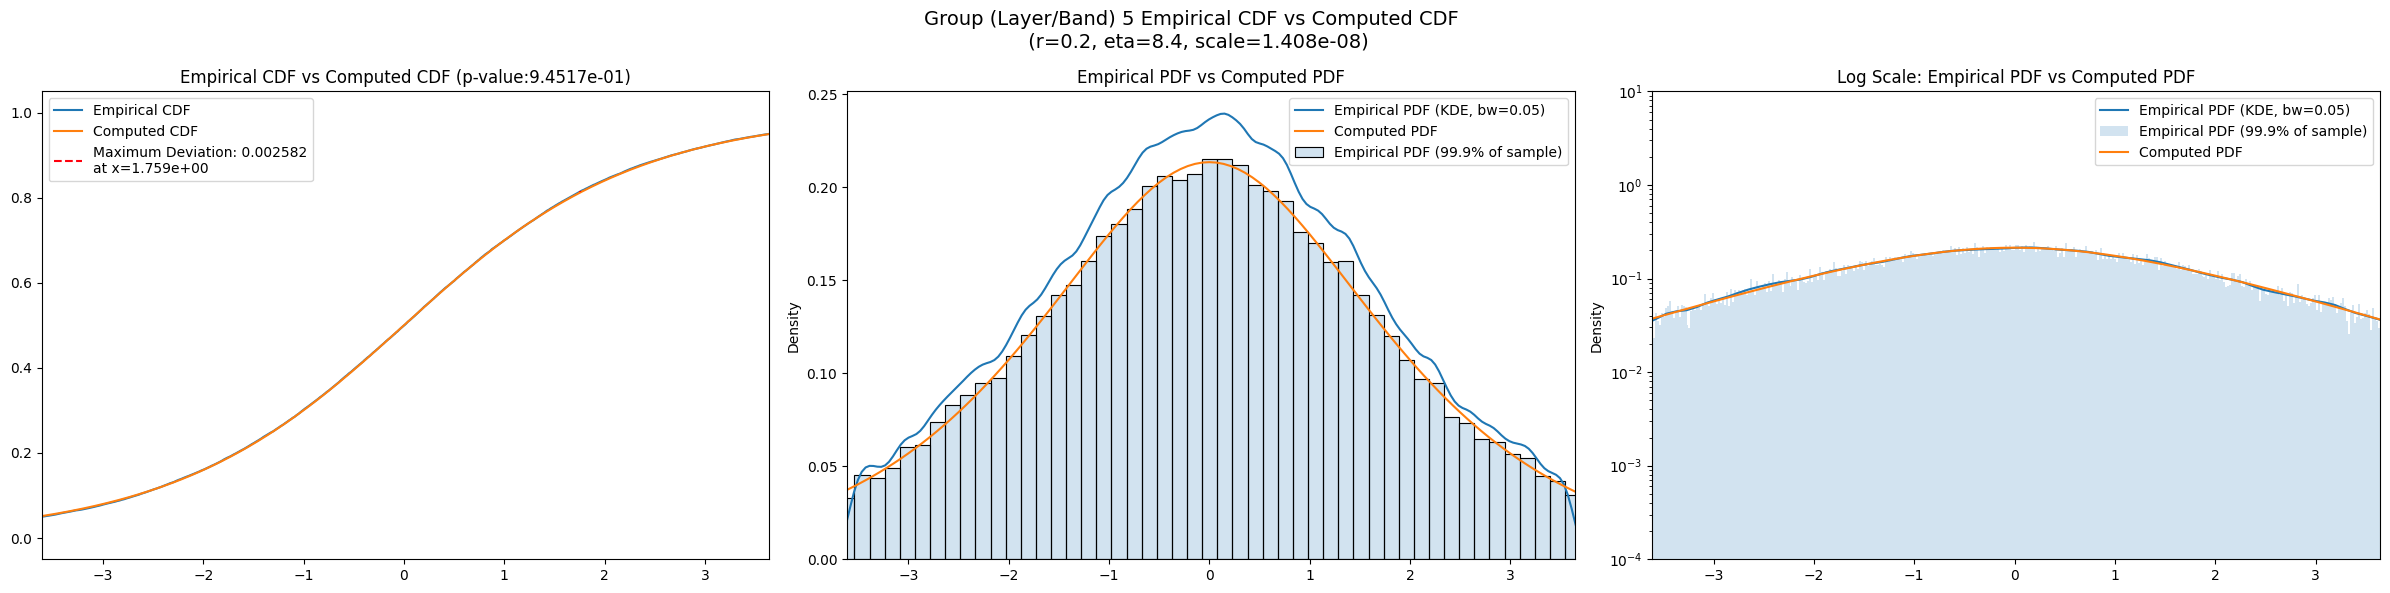

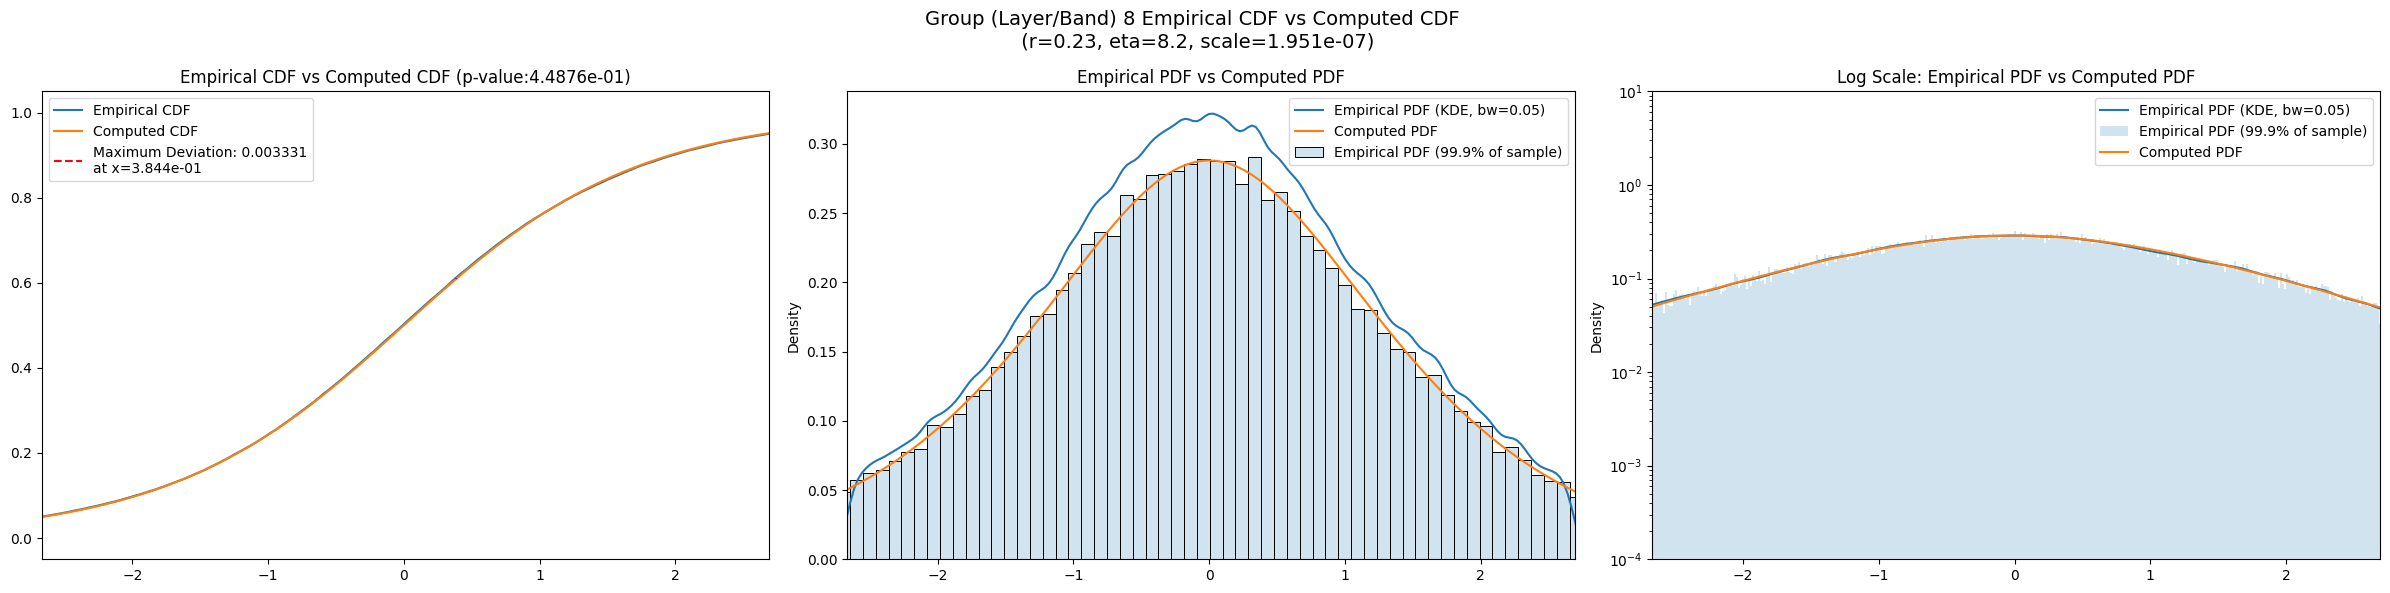

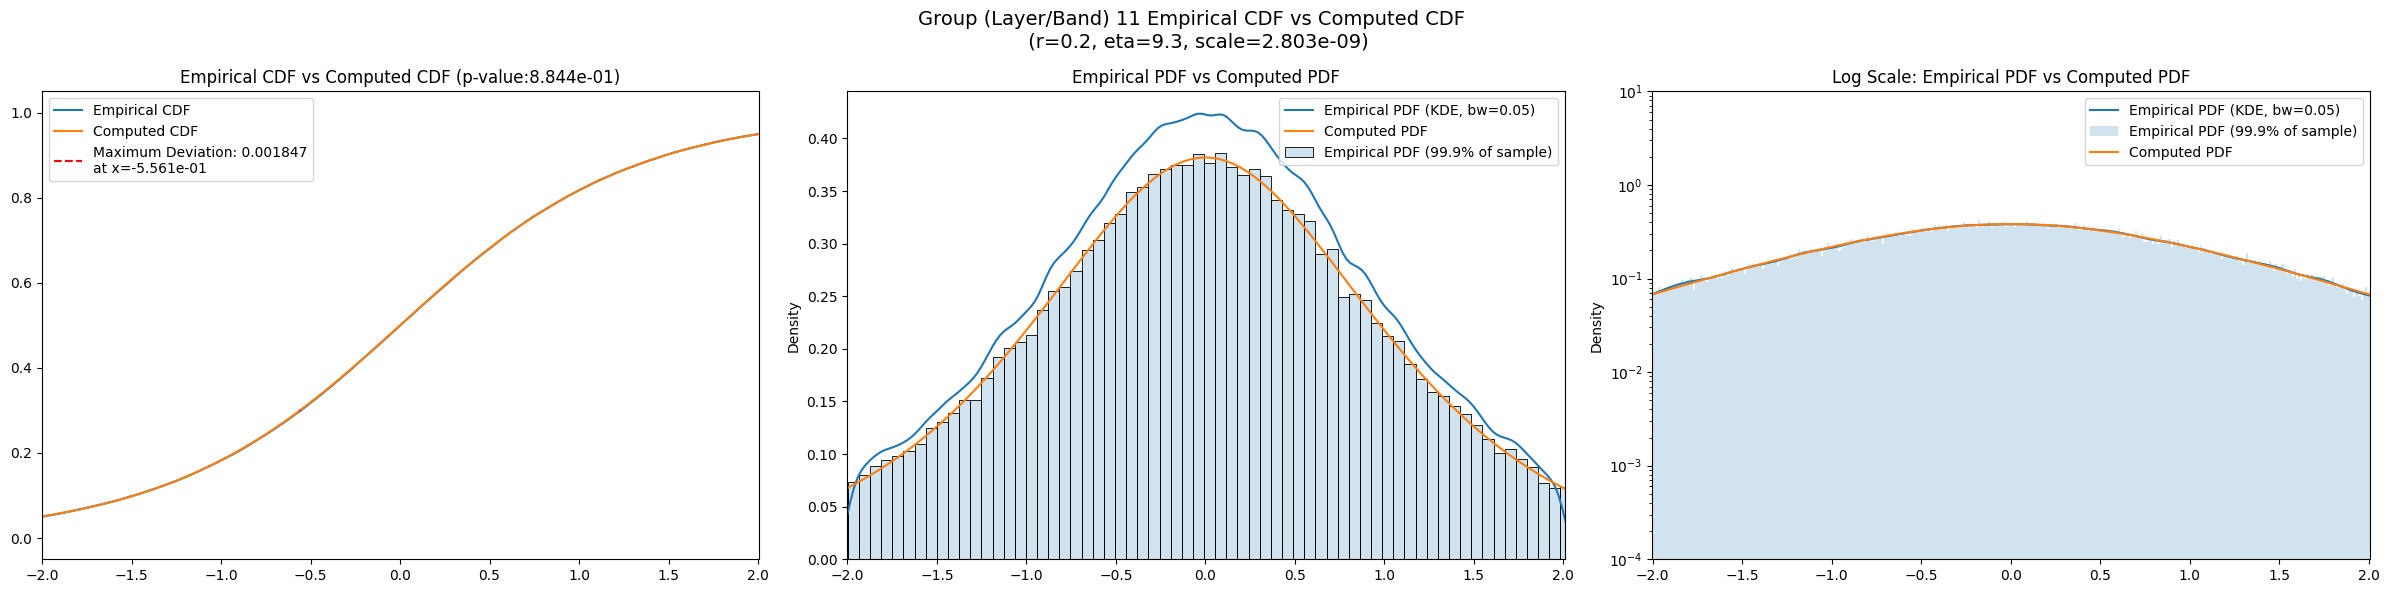

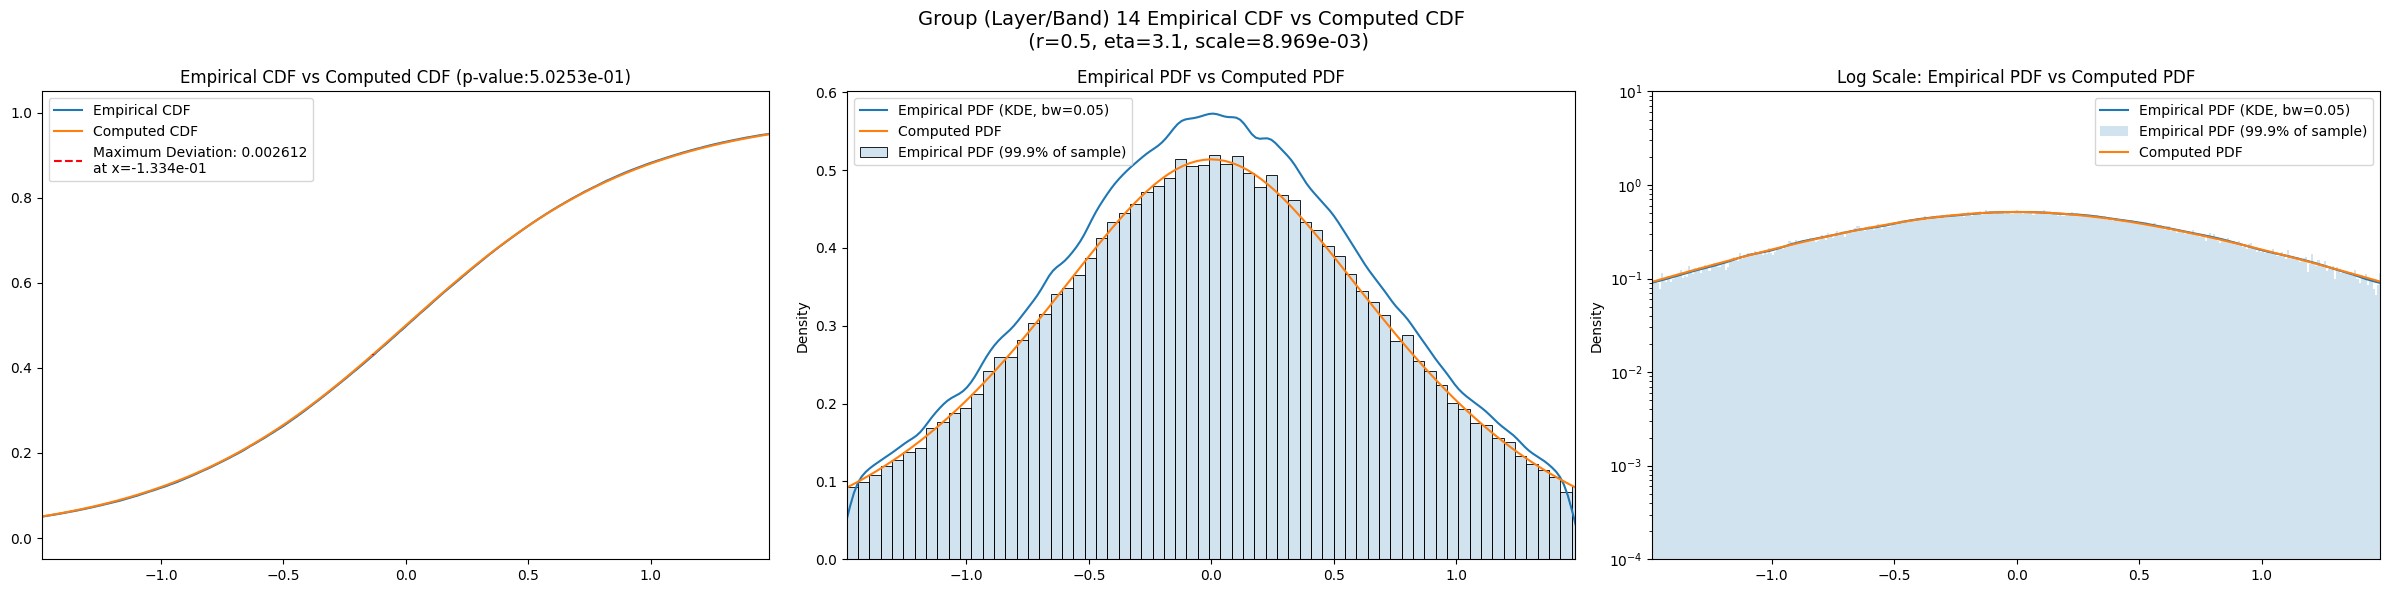

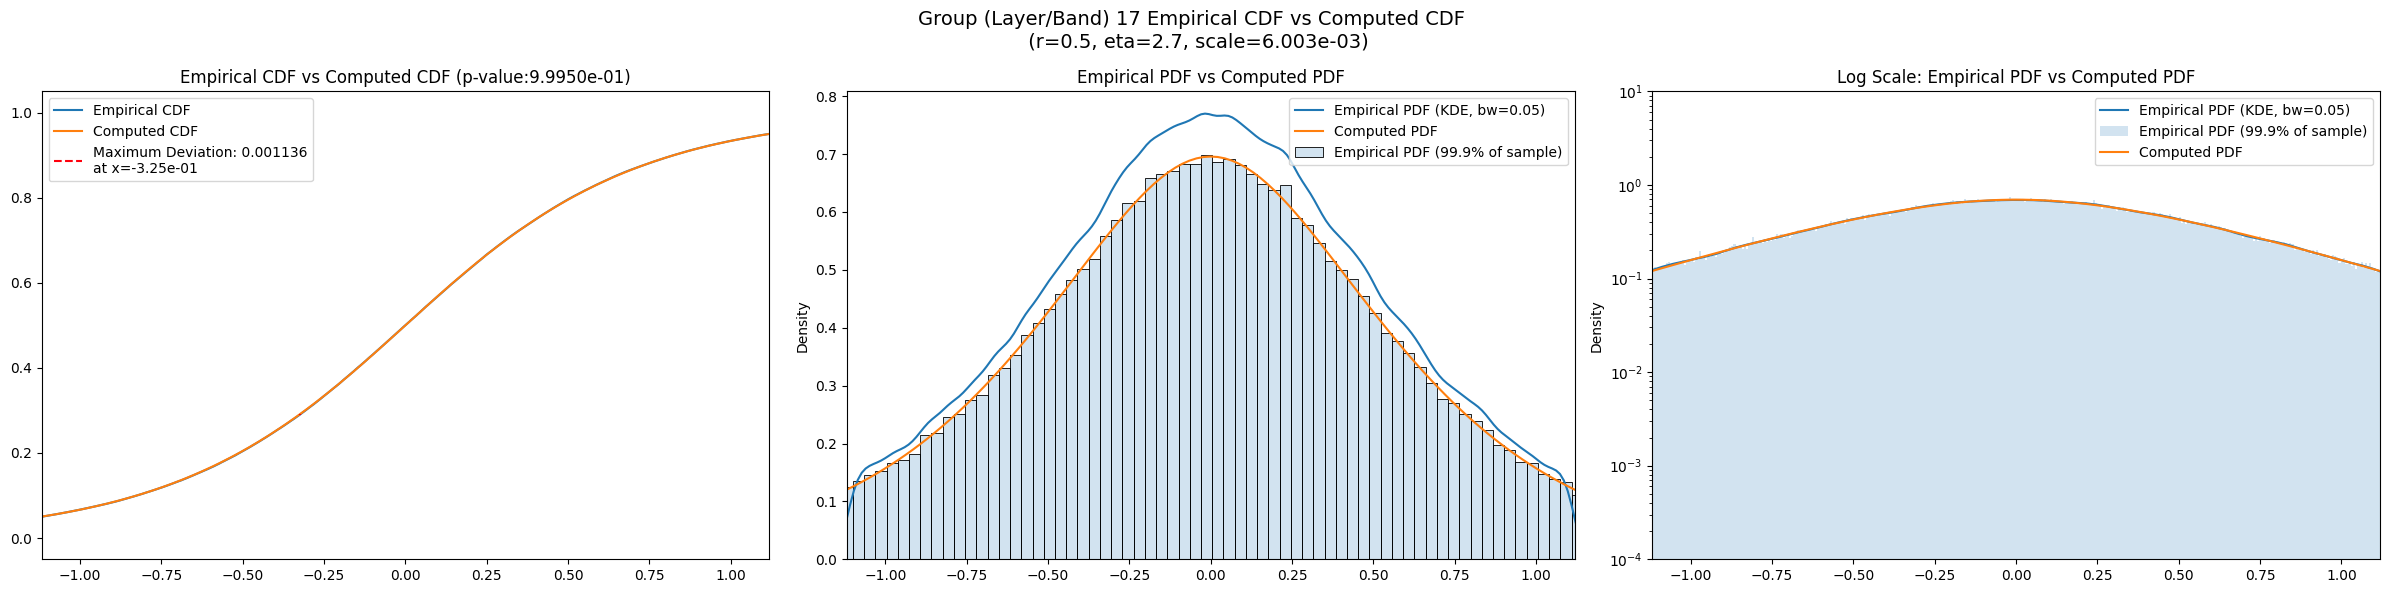

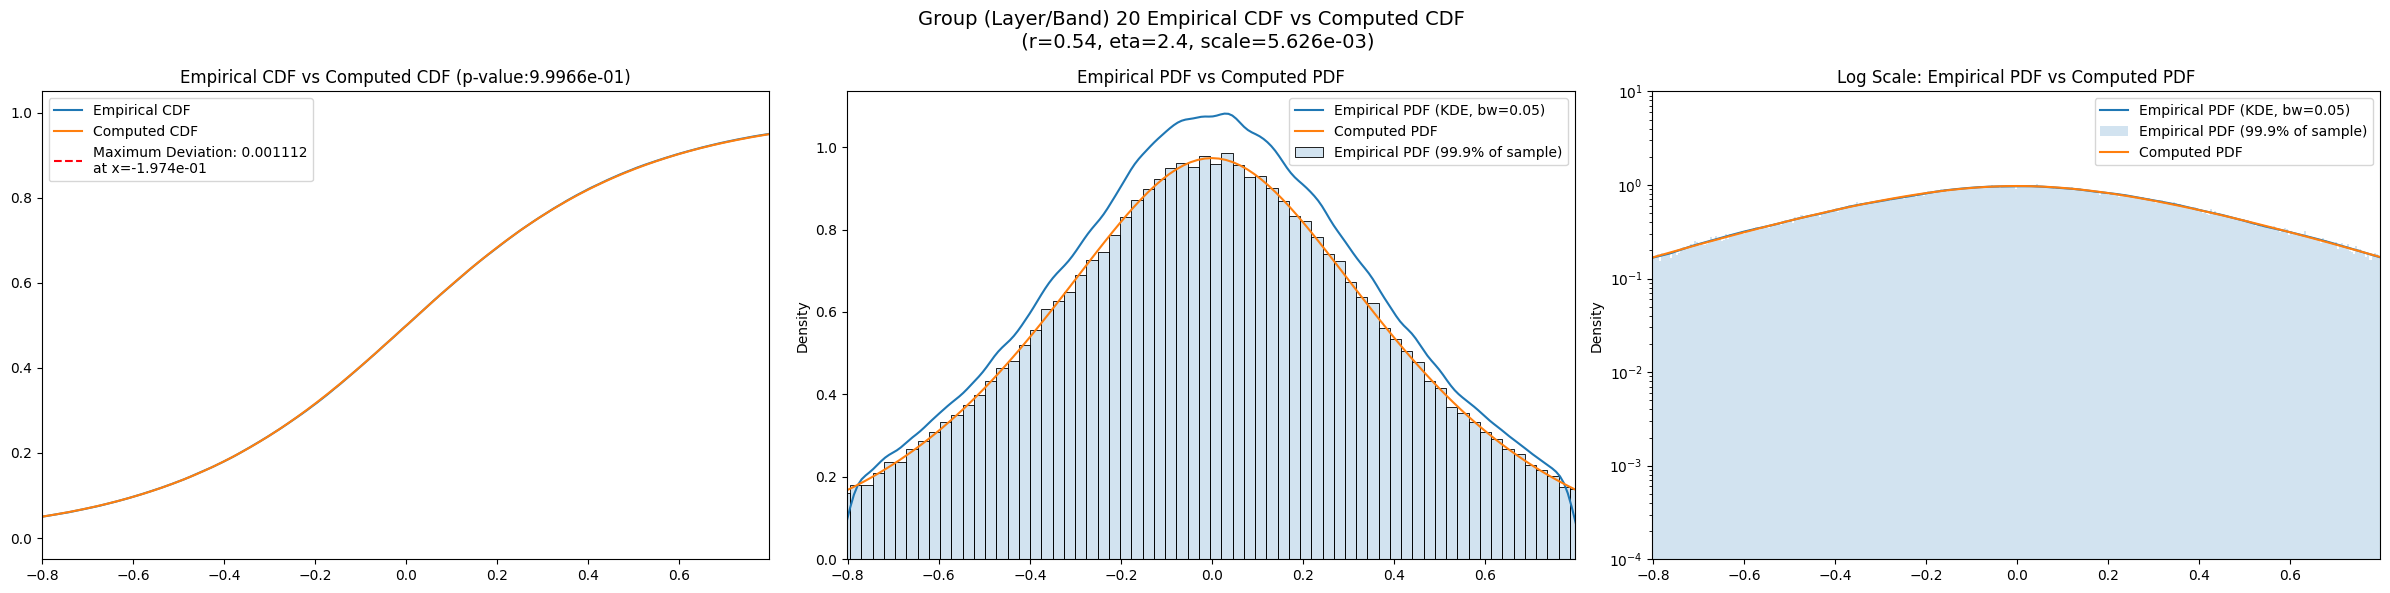

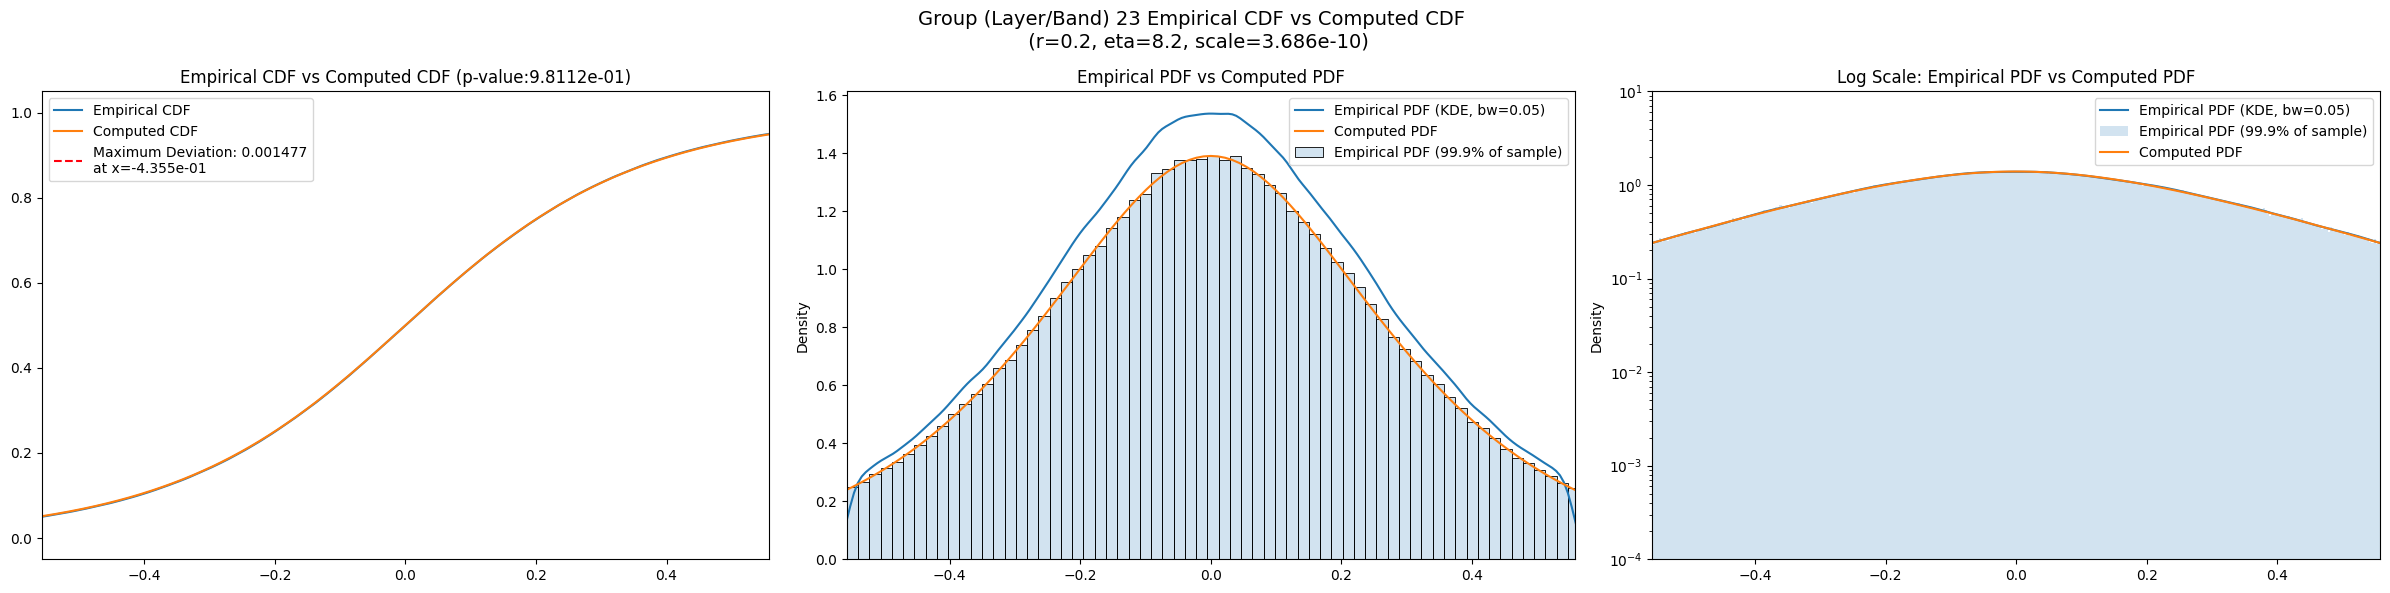

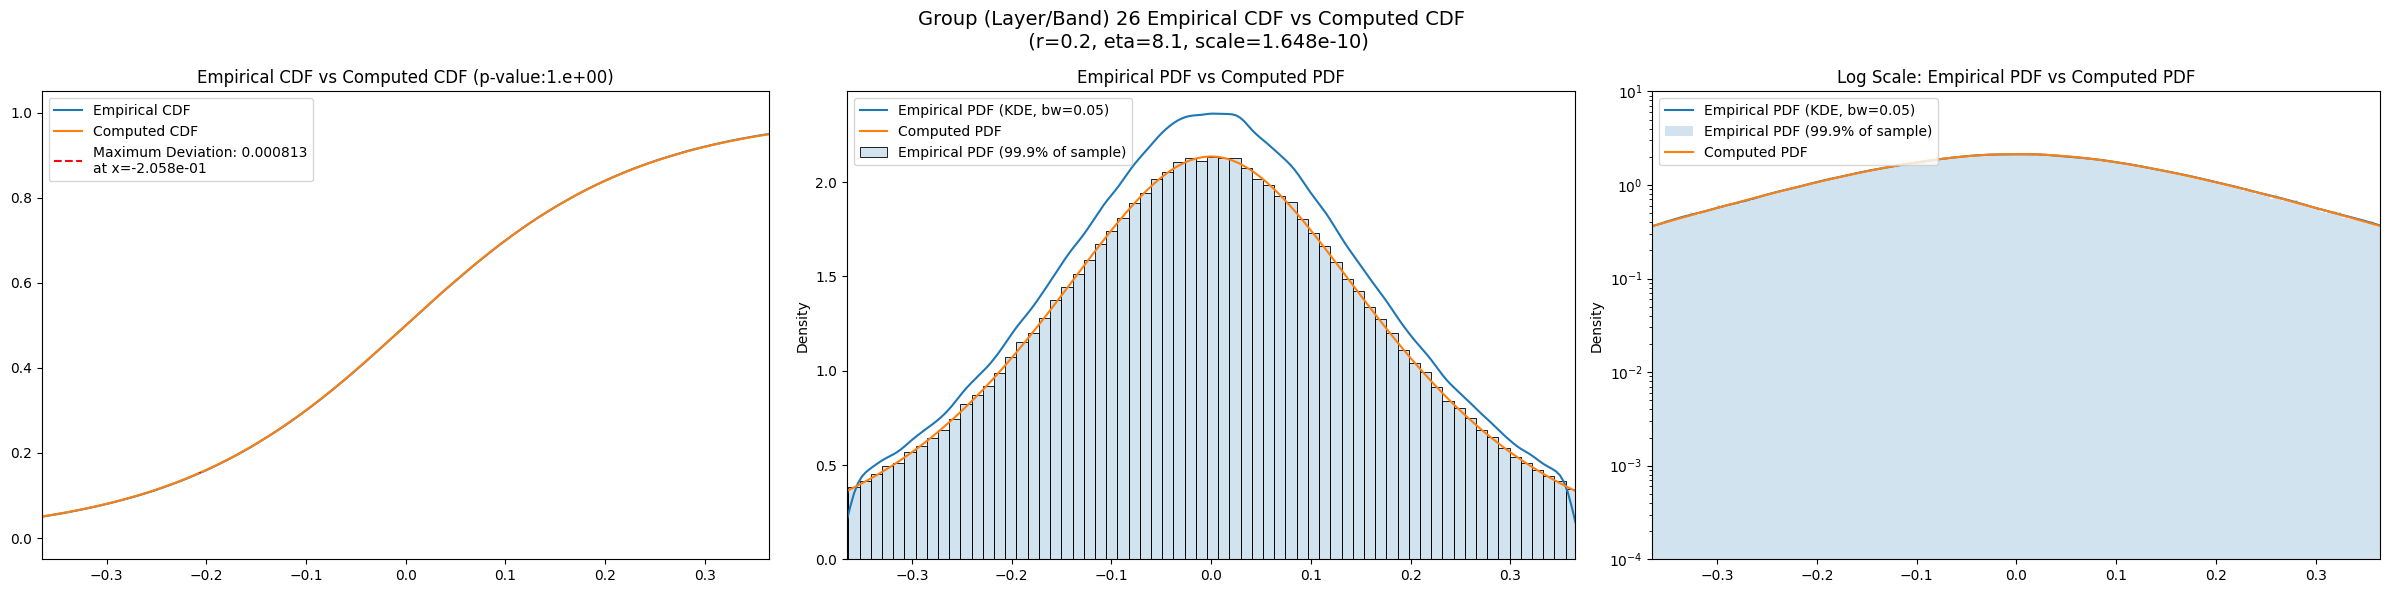

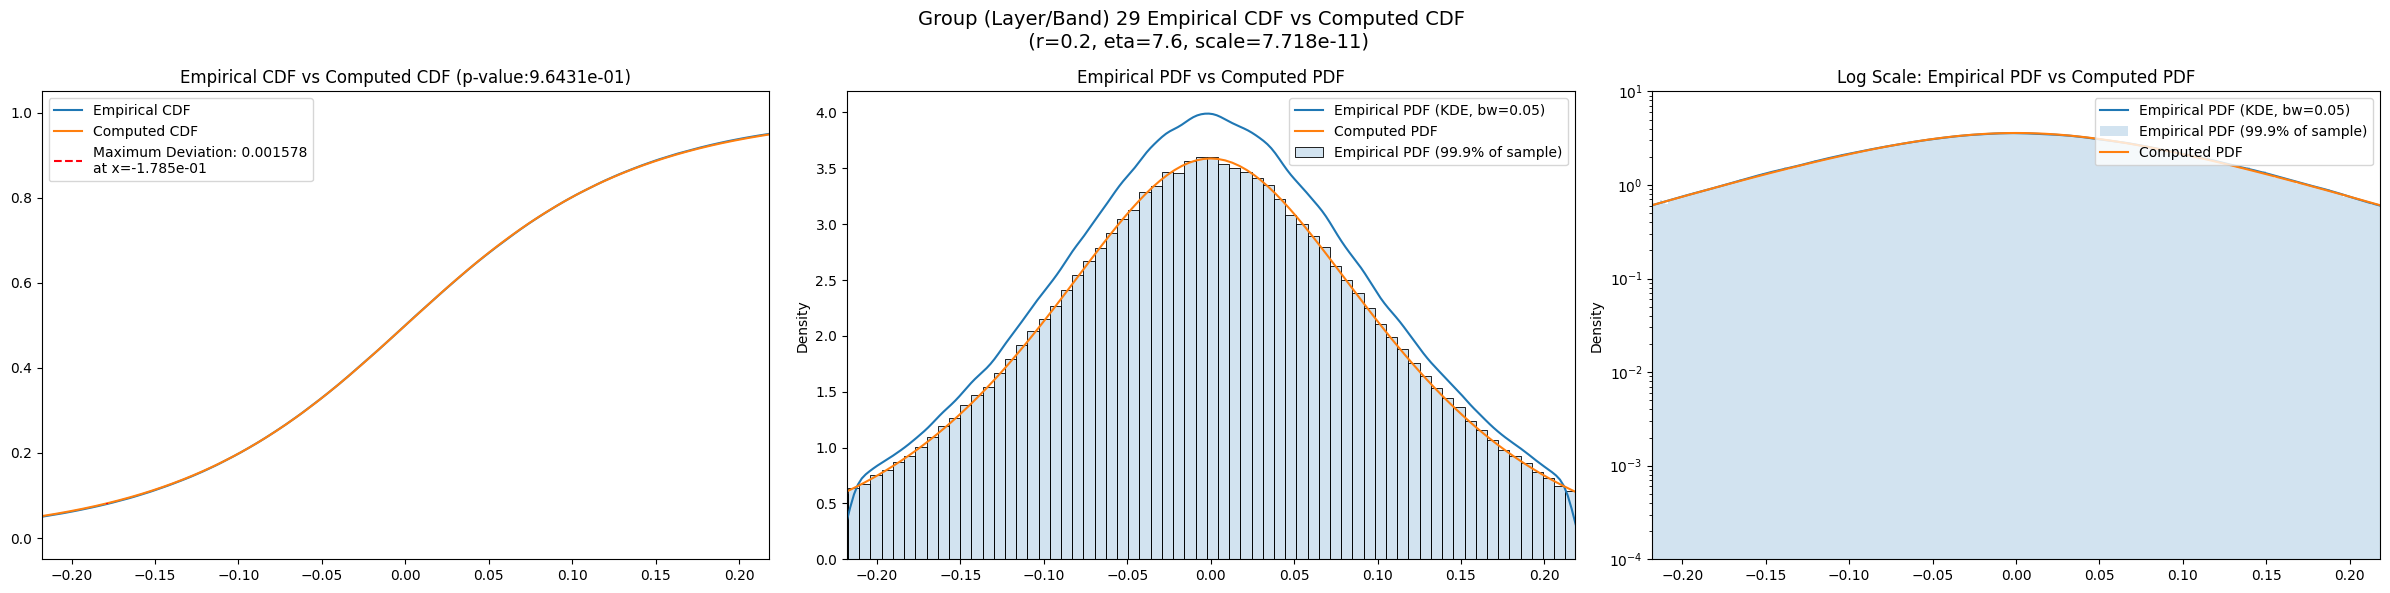

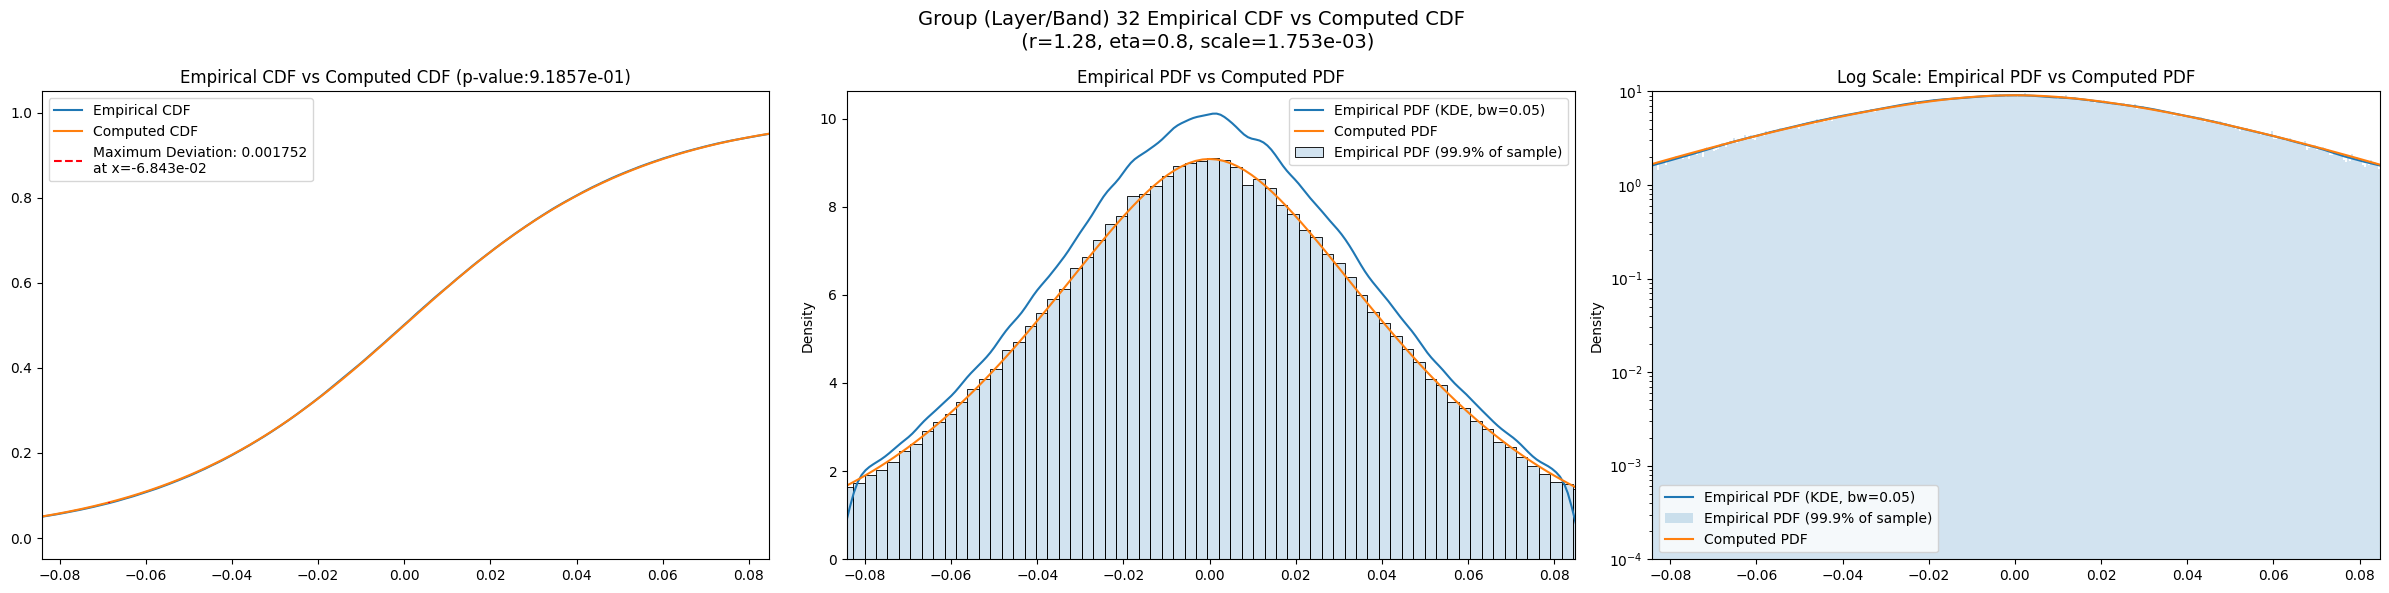

In [15]:
for group in GROUPS:
    group_info = master_df.loc[group]
    best_r = group_info['best_r']
    best_eta = group_info['best_eta']
    best_scale = group_info['best_scale']
    fig = visualize_cdf_pdf(sample = group_data_map[group], 
                    params = (best_r, best_eta, best_scale), 
                    log_scale = True,
                    group = group)
    fig.savefig(os.path.join(CWD, "plots", f'compare_cdf_pdf_layer_{group}.jpg'), bbox_inches = 'tight', dpi = 100)

## Comparing with Gaussian and Laplace Priors

In [16]:
def generate_func(sample, distro, *args, n_samples=200):
    if distro == 'gaussian' or distro == 'normal':
        def var_func(var):
            cdf = scipy.stats.norm(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'laplace':
        def var_func(var):
            cdf = scipy.stats.laplace(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 't':
        def var_func(var):
            cdf = scipy.stats.t(df=2, scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'prior_r':
        eta = args[0]
        def r_func(r):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return r_func
    elif distro == 'prior_eta':
        r = args[0]
        def eta_func(eta):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return eta_func
    elif distro == 'prior':
        def r_eta_func(params):
            r = params[0]
            eta = params[1]
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample, cdf)
        return r_eta_func
    elif distro == 'prior_with_scale':
        def r_eta_scale_func(params):
            r = params[0]
            eta = params[1]
            scale = params[2]
            print(r, eta, scale)
            cdf = compute_prior_cdf(r = r, eta = eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample/ np.sqrt(scale), cdf)
        return r_eta_scale_func

    print("Please enter a valid argument for `distro`: 'gaussian', 'laplace', 'prior_r', 'prior_eta', 'prior','prior_with_scale', 't'")

In [17]:
master_df_path = Path(os.path.join(CWD, "CSVs", 'master_df.csv'))

if RERUN or not master_df_path.exists():
    upper_bound = int(1e6)
    for group in GROUPS:
        norm_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'gaussian'), method = 'bounded', bounds = (0, upper_bound))
        laplace_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'laplace'), method = 'bounded', bounds = (0, upper_bound))
        t_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 't'), method = 'bounded', bounds = (0, upper_bound))
        
        master_df.loc[group, 'param_gaussian'] = round_to_sigfigs(norm_result['x'], 6)
        master_df.loc[group, 'kstest_stat_gaussian'] = round_to_sigfigs(norm_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_gaussian'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_gaussian']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6) 

        master_df.loc[group, 'param_t'] = round_to_sigfigs(t_result['x'], 6)
        master_df.loc[group, 'kstest_stat_t'] = round_to_sigfigs(t_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_t'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_t']), 6) 

        master_df.loc[group, 'kstest_pval_gengamma'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_best']))

    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df.csv'))
    
master_df = pd.read_csv(os.path.join(CWD, "CSVs", 'master_df.csv'), index_col = GROUP)
master_df

obs_var  var_lower  var_upper   obs_kurt  kurt_lower  kurt_upper  \
band                                                                      
2     9.598991   9.110358  10.110742   2.019593    1.471349    2.704436   
5     5.091696   4.837473   5.358150   1.903983    1.275784    2.832162   
8     2.783870   2.644551   2.927817   1.937604    1.312301    2.837549   
11    1.574336   1.491815   1.662111   2.370253    1.365877    4.514517   
14    0.857636   0.814612   0.903813   2.089291    1.275146    4.009901   
17    0.483346   0.458738   0.509555   2.151878    1.293355    4.513294   
20    0.247357   0.234671   0.261674   2.416864    1.276760    9.097979   
23    0.120827   0.114650   0.127477   2.248149    1.370794    4.596758   
26    0.052979   0.049797   0.057025   4.653831    1.694718   18.998148   
29    0.020105   0.018494   0.022679  13.155254    2.838861   66.098460   
32    0.002715   0.002586   0.002847   1.459712    1.005672    2.262223   

      total_samples  kstest_stat_initial  initial_r  initial_eta  ...  \
band                                                              ...   
2           31800.0             0.003425        1.0          0.7  ...   
5           41340.0             0.002262        0.2          8.4  ...   
8           66780.0             0.003265        0.2          8.5  ...   
11         104940.0             0.001649        0.2          9.3  ...   
14         162180.0             0.002545        0.5          3.1  ...   
17         257580.0             0.000928        0.5          2.7  ...   
20         381600.0             0.000983        0.5          2.7  ...   
23         610560.0             0.001120        0.2          8.2  ...   
26         973080.0             0.000723        0.2          8.1  ...   
29        1376940.0             0.001159        0.2          7.6  ...   
32         419760.0             0.001588        1.2          0.9  ...   

      param_gaussian  kstest_stat_gaussian  kstest_pval_gaussian  \
band                                                               
2           2.766020              0.015910          2.016780e-07   
5           2.053980              0.013652          4.018960e-07   
8           1.510040              0.014275          2.993590e-12   
11          1.136050              0.013043          6.167150e-16   
14          0.842986              0.012871          9.111470e-24   
17          0.630848              0.013616          6.538190e-42   
20          0.451245              0.013377          9.678910e-60   
23          0.314616              0.013206          6.496660e-93   
26          0.205724              0.013474         7.106830e-154   
29          0.123049              0.013392         6.556500e-215   
32          0.048181              0.011814          2.583560e-51   

      param_laplace  kstest_stat_laplace  kstest_pval_laplace   param_t  \
band                                                                      
2          2.451610             0.016523         5.689850e-08  1.993710   
5          1.808790             0.017871         6.708080e-12  1.458490   
8          1.343610             0.018332         6.334000e-20  1.079410   
11         1.005180             0.017897         1.251290e-29  0.809651   
14         0.748671             0.018921         7.223590e-51  0.602342   
17         0.556817             0.016885         3.231920e-64  0.446727   
20         0.397381             0.016803         5.085920e-94  0.320516   
23         0.277562             0.016826        1.410420e-150  0.224077   
26         0.181257             0.016557        3.795860e-232  0.145996   
29         0.108190             0.016350                  NaN  0.087426   
32         0.042415             0.018473        7.304810e-125  0.034146   

      kstest_stat_t  kstest_pval_t  kstest_pval_gengamma  
band                                                      
2          0.019143   1.488480e-10              0.863823  
5          0.020131   5.517930e-15         

## Results

In [18]:
import pandas as pd
import os
master_df = pd.read_csv(os.path.join(os.getcwd(), "CSVs", 'master_df.csv'), index_col = 0)

In [19]:
master_df.filter(regex="kstest_stat.*")

kstest_stat_initial  kstest_stat_cutoff_0.05  kstest_stat_best  \
band                                                                   
2                0.003425                 0.007611          0.003361   
5                0.002262                 0.006675          0.002262   
8                0.003265                 0.005253          0.003259   
11               0.001649                 0.004191          0.001649   
14               0.002545                 0.003371          0.002545   
17               0.000928                 0.002675          0.000928   
20               0.000983                 0.002198          0.000933   
23               0.001120                 0.001738          0.001120   
26               0.000723                 0.001377          0.000723   
29               0.001159                 0.001157          0.001159   
32               0.001588                 0.002096          0.001572   

      kstest_stat_gaussian  kstest_stat_laplace  kstest_stat_t  
band                                                            
2                 0.015910             0.016523       0.019143  
5                 0.013652             0.017871       0.020131  
8                 0.014275             0.018332       0.020292  
11                0.013043             0.017897       0.020099  
14                0.012871             0.018921       0.020455  
17                0.013616             0.016885       0.019349  
20                0.013377             0.016803       0.019458  
23                0.013206             0.016826       0.019407  
26                0.013474             0.016557       0.018817  
29                0.013392             0.016350       0.018653  
32                0.011814             0.018473       0.020809

In [20]:
master_df.filter(regex="best.*")

best_augmented_var  kstest_stat_best  best_r  best_eta    best_scale  \
band                                                                         
2               9.229053          0.003361    0.99       0.7  4.110970e+00   
5               5.091696          0.002262    0.20       8.4  1.408139e-08   
8               2.681151          0.003259    0.23       8.2  1.950517e-07   
11              1.541339          0.001649    0.20       9.3  2.803179e-09   
14              0.841638          0.002545    0.50       3.1  8.968863e-03   
17              0.474015          0.000928    0.50       2.7  6.003235e-03   
20              0.242687          0.000933    0.54       2.4  5.626325e-03   
23              0.120827          0.001120    0.20       8.2  3.686045e-10   
26              0.051408          0.000723    0.20       8.1  1.648367e-10   
29              0.018621          0.001159    0.20       7.6  7.718027e-11   
32              0.002650          0.001572    1.28       0.8  1.753040e-03   

      best_exclude_cutoff  
band                       
2                    25.0  
5                     0.0  
8                    50.0  
11                   25.0  
14                   25.0  
17                   25.0  
20                   25.0  
23                    0.0  
26                   25.0  
29                   50.0  
32                   50.0

In [21]:
eng.quit()